In [1]:
import ROOT
from ROOT import TFile
from ROOT import RooDataSet, RooDataHist, RooArgSet, RooArgList, RooRealVar, RooFormulaVar, RooWorkspace
from ROOT import RooBDecay, RooTruthModel, RooFFTConvPdf, RooHistPdf, RooDecay
from ROOT import gPad , TCanvas , TPaveText , TLegend

In [2]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import zfit

/opt/anaconda3/envs/root-env/lib/python3.12/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [3]:
prompt_up = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root")
# data24_prompt_withut_magup
prompt_down = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000001_1.data24.root")
# data24_prompt_withut_magdown

mcprompt_up = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237601/0000/00237601_00000001_1.mc.root")
# mc24_magup_prompt_bstojpsiphi_13144011_hlt1,2,
mcprompt_down = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237610/0000/00237610_00000001_1.mc.root")
# mc24_magdown_prompt_bstojpsiphi_13144011_hlt1,2,

mcdata_up = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237559/0000/00237559_00000001_1.mc.root")
# mc24_magup_bstojpsiphi_13144011_hlt1,2,
mcdata_down = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237560/0000/00237560_00000001_1.mc.root")
# mc24_magdown_bstojpsiphi_13144011_hlt1,2,

In [4]:
mcdata_up.Get("BsToJpsiPhi_Detached/DecayTree").ls()

OBJ: TTree	DecayTree	DecayTree : 0 at: 0x110b11f50


In [5]:
branch_list = mcdata_up.Get("BsToJpsiPhi_Detached/DecayTree").GetListOfBranches()

for branch in branch_list:
    print(branch.GetName())

NPVs
ALLPVX
ALLPVY
ALLPVZ
BUNCHCROSSING_ID
BUNCHCROSSING_TYPE
EVENTNUMBER
GPSTIME
Hlt1D2KKDecision
Hlt1D2KPiDecision
Hlt1D2PiPiDecision
Hlt1DiMuonHighMassDecision
Hlt1DiMuonLowMassDecision
Hlt1DiMuonNoIPDecision
Hlt1DiMuonNoIP_ssDecision
Hlt1DiMuonSoftDecision
Hlt1DisplacedDiMuonDecision
Hlt1DisplacedLeptonsDecision
Hlt1GECPassthroughDecision
Hlt1KsToPiPiDecision
Hlt1LowPtDiMuonDecision
Hlt1LowPtMuonDecision
Hlt1OneMuonDecision
Hlt1OneMuonTrackLineDecision
Hlt1PassthroughDecision
Hlt1SingleHighEtDecision
Hlt1SingleHighPtMuonDecision
Hlt1TrackMVADecision
Hlt1TrackMuonMVADecision
Hlt1TwoTrackKsDecision
Hlt1TwoTrackMVACharmXSecDecision
Hlt1TwoTrackMVADecision
Hlt1_TCK
Hlt2B2CC_BdToJpsiKstar_JpsiToMuMu_DetachedDecision
Hlt2B2CC_BsToJpsiPhiDecision
Hlt2B2CC_BsToJpsiPhi_DetachedDecision
Hlt2B2CC_BsToJpsiPhi_ExtraMuonDecision
Hlt2B2CC_BsToJpsiPhi_JpsiToEE_DetachedDecision
Hlt2B2CC_BuToJpsiKplus_JpsiToMuMu_DetachedDecision
Hlt2B2OC_BdToDsmPi_DsmToKpKmPimDecision
Hlt2_TCK
NLongTracks
NPV
ODINTC

# Function

In [6]:
def data_extraction_root_to_pd (data_paths,braches,tree_path):
    """
    example: 
    prompt_paths = [
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000001_1.data24.root"
    ]
    
    braches=["Bs_DTF_PV_CTAU", "Bs_DTF_PV_CTAUERR","RUNNUMBER"]
    
    tree_path = "BsToJpsiPhi/DecayTree"
    """
    all_data = []

    for path in data_paths:
        with uproot.open(path) as file:
            tree = file[tree_path] 
    
            branches = tree.arrays(
                braches,
                library="pd"
            )
    
            all_data.append(branches)

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

In [7]:
def quantiles_cutting_cal(selected_condition_quantity, filtered_quantity, quantiles, combined_df,cut_on_condata,
                          cut_on_quantity,unit=None,fitting_plots=False, cutting_binplot=False, mu_mean=None
                          ):
    """
    First limit the data (x-axis) according to cut_neg_x,cut_pos_x, then “cut”/select according to the established quantile.
    Fitting each cut plot


    Returns:
    dict:  fitting_results
    """
    
    fitting_results = {
        "quantile_range": [],
        "mean": [],
        "mean_error": [],
        "sigma": [],
        "sigma_error": [],
        "sigma_width_bar": [],
        "mid_bin_point": []
    }
######################### Fitting ######################### 
    for i in range(len(quantiles) - 1):
        # Data processing
        cut_df = combined_df[
            (combined_df[selected_condition_quantity] > quantiles[i]) & 
            (combined_df[selected_condition_quantity] < quantiles[i + 1])
        ]
        Ctau_data = cut_df[filtered_quantity]
        Ctau_data_filtered = Ctau_data[(Ctau_data >= cut_on_quantity[0]) & (Ctau_data <= cut_on_quantity[1])]

        # to zfit
        obs = zfit.Space(filtered_quantity, limits=(cut_on_quantity[0], cut_on_quantity[1]))
        Ctau_data_zfit = zfit.Data.from_numpy(obs=obs, array=Ctau_data_filtered.values)

        # Gauss
        mean = zfit.Parameter(f"mean_{i}", cut_on_quantity[1]/2, cut_on_quantity[0], cut_on_quantity[1])
        sigma = zfit.Parameter(f"sigma_{i}", cut_on_quantity[1]/2, 0, cut_on_quantity[1])
        amplitude = zfit.Parameter(f"amplitude_{i}", 1, 0, 10)
        gauss = zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
        if mu_mean is not None:
            mean = mu_mean
            gauss = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
        else:
            gauss = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)

        # Loss function and minimizer
        nll = zfit.loss.UnbinnedNLL(model=gauss, data=Ctau_data_zfit)
        minimizer = zfit.minimize.Minuit()

        # Fitting
        result = minimizer.minimize(nll)
        errors = result.hesse()
        
######################### Fitting parameters ######################### 
        # Save fitting parameters
        if result.converged:
            # Extract fitted parameter values
            sigma_val = sigma.value().numpy()
            if mu_mean is not None:
                mean_val = mean
            else:
                mean_val = mean.value().numpy()

            # Extract error bars using the Hesse method
            errors = result.hesse()
            if mu_mean is not None:
                mean_error = 0
            else:
                mean_error = errors[mean]['error']
            sigma_error = errors[sigma]['error']

            # Append results to the dictionary
            fitting_results["quantile_range"].append((quantiles[i], quantiles[i + 1]))
            fitting_results["mean"].append(mean_val)
            fitting_results["mean_error"].append(mean_error)
            fitting_results["sigma"].append(sigma_val)
            fitting_results["sigma_error"].append(sigma_error)
            fitting_results["sigma_width_bar"].append((quantiles[i+1] - quantiles[i]) / 2)
            fitting_results["mid_bin_point"].append(quantiles[i] + (quantiles[i+1] - quantiles[i]) / 2)
        else:
            # Append None values for failed fits
            fitting_results["quantile_range"].append((quantiles[i], quantiles[i + 1]))
            fitting_results["mean"].append(None)
            fitting_results["mean_error"].append(None)
            fitting_results["sigma"].append(None)
            fitting_results["sigma_error"].append(None)
            fitting_results["sigma_width_bar"].append(None)
            fitting_results["mid_bin_point"].append(None)

#######################################################################
        # Plot
        x_plot = np.linspace(cut_on_quantity[0], cut_on_quantity[1], 1000)
        y_plot = zfit.run(gauss.pdf(x_plot, norm_range=obs))
        
        if fitting_plots is not False:
            plt.figure(figsize=(10, 6))
            plt.hist(Ctau_data_filtered, bins=300, range=(cut_on_quantity[0]*1.3, cut_on_quantity[1]*1.3), density=True, color='blue', alpha=0.3, label='Data')
            plt.plot(x_plot, y_plot, color='red', lw=2, label=f'Fit for quantile {quantiles[i]:.5f}-{quantiles[i + 1]:.5f}')
            plt.title(f"{filtered_quantity} for quantile {quantiles[i]:.5f}-{quantiles[i + 1]:.5f}")
            plt.xlabel(filtered_quantity)
            plt.ylabel("Count")
            plt.legend()
            plt.grid(True)
            plt.show()
######################### colourfull histogram ######################### 
    data = combined_df[selected_condition_quantity].values
    binned_data = []

    # go through all quantile，and extract wanted range of filtered_quantity
    for i in range(len(quantiles) - 1):
        cut_df = combined_df[(combined_df[selected_condition_quantity] > quantiles[i]) & (combined_df[selected_condition_quantity] <= quantiles[i + 1])]
        Ctau_data = cut_df[selected_condition_quantity].values
        binned_data.append(Ctau_data)
#        print(f"Bin {i+1} ({quantiles[i]:.5f} to {quantiles[i+1]:.5f}) contains {len(Ctau_data)} data points.")

    plt.figure(figsize=(10, 6))

    if cutting_binplot is not False:
        for i in range(len(binned_data)):
            plt.hist(binned_data[i], bins=1000, alpha=0.5, range=(cut_on_condata[0]*0.8, cut_on_condata[1]*1.2), label=f'Quantile {i+1}: {quantiles[i]:.5f} - {quantiles[i+1]:.5f}')

        if unit is not None:
            plt.xlabel(f"{selected_condition_quantity}, {'('}{unit}{')'}")
        else:
            plt.xlabel(selected_condition_quantity)
        plt.ylabel('Counts')
        plt.legend()
        plt.show()   
     

    return fitting_results

In [8]:
def sig_vs_sig_t(selected_condition_quantity, filtered_quantity, combined_df, quantiles, fitting_results,xyplot=False,
                x_unit=None, y_unit=None):
    binned_data = []
    sigmas = fitting_results["sigma"]
    mid_bin_point = fitting_results["mid_bin_point"]
    sigma_width_bar = fitting_results['sigma_width_bar']
    sigma_error =   fitting_results["sigma_error" ]
 
    # go through quantile and extract Bs_DTF_PV_CTAU
    for i in range(len(quantiles) - 1):
        cut_df = combined_df[(combined_df[selected_condition_quantity] > quantiles[i]) & (combined_df[selected_condition_quantity] <= quantiles[i + 1])]
        Ctau_data = cut_df[filtered_quantity].values
        binned_data.append(Ctau_data)
    
    # Normalization
    total_data_points = sum([len(b) for b in binned_data])

    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # plot sigma on left y-axis
    ax1.errorbar(mid_bin_point,sigmas,  xerr=sigma_width_bar,yerr=sigma_error, fmt='o', color='blue')
    if x_unit is not None:
        plt.xlabel(f"{selected_condition_quantity}, {'('}{x_unit}{')'}")
    else:
        plt.xlabel(selected_condition_quantity)
        
    if y_unit is not None:
        plt.ylabel(f"{'Fitted Sigma'}, {'('}{y_unit}{')'}")
    else:
        plt.ylabel('Fitted Sigma', color='blue')
    
    fit_params = np.polyfit(mid_bin_point, sigmas, 1)  
    extended_x = np.linspace( quantiles[0]*0.98,  quantiles[-1]*1.05, 100)  
    fit_line = np.polyval(fit_params, extended_x)  
    extended_y= np.linspace(0 ,  quantiles[-1]*1.3, 100)

    #ax1.plot(mid_bin_point, fit_line, color='red', linestyle='-', label='Linear Fit')
    ax1.plot(extended_x, fit_line, color='k', linestyle='-')
    if xyplot is not False:
        ax1.plot(extended_y, extended_y, color='green', linestyle='-', label='y=x')  
    # second qunatity on right-axis
    ax2 = ax1.twinx()

    # normalization for background plot
    for i in range(len(binned_data)):
        bin_range = (quantiles[i+1] - quantiles[i])
        normalized_height = len(binned_data[i]) / (1.15*total_data_points * bin_range)  # 归一化高度
#        ax2.bar(quantiles[i], normalized_height, width=bin_range, alpha=0.3, align='edge', label=f' {i+1}: {quantiles[i]:.4f} - {quantiles[i+1]:.4f}')
        ax2.bar(quantiles[i], normalized_height, width=bin_range, alpha=0.3, align='edge')

    ax2.set_ylabel('Normalized Counts (Density)', color='gray')
#    ax2.set_ylim(0, 200)  
 #   ax1.set_xlim(0, 0.08)
 #   ax1.set_ylim(0, 0.08)
    fig.tight_layout()
#    plt.legend()
    plt.show()

    return fit_params 


In [9]:
def gaussfit_without_BG (fitting_quantity, combined_df,cut_on_data,plot=False,mean=None,zfit_spc_lim = None, sw=None ):
    # data Bs_BPVLTIME in [-0.0001, 0.0001]
    data = combined_df[(combined_df[fitting_quantity] >= cut_on_data[0]) & (combined_df[fitting_quantity] <= cut_on_data[1])]  
    data_np = data[fitting_quantity].values

    # define zfit space 
    if zfit_spc_lim is not None:
        obs = zfit.Space(fitting_quantity, limits=(zfit_spc_lim[0], zfit_spc_lim[1]))
    else:
        obs = zfit.Space(fitting_quantity, limits=(cut_on_data[0], cut_on_data[1]))
    

    # load data zfit
    if sw is not None:
        weights_np = data[sw].values
        data = zfit.Data.from_numpy(obs=obs, array=data_np, weights=weights_np)
    else:
        data = zfit.Data.from_numpy(obs=obs, array=data_np)

    # gaussian
    
        
    sigma = zfit.Parameter("sigma", 0.01, 0, abs(cut_on_data[1]))
    if mean is not None:
        if len(mean) == 1:
            mu = mean
        else:
            mu =  zfit.Parameter("mean", 0.0, mean[0], mean[1])
    else:
        mu = zfit.Parameter("mean", 0.0, cut_on_data[0], cut_on_data[1])
    
    gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
  

    # combined model
    model = gauss

    # fitting
    nll = zfit.loss.UnbinnedNLL(model=model, data=data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    # plot
    x_plot = np.linspace(cut_on_data[0], cut_on_data[1], 1000)
    y_plot = zfit.run(model.pdf(x_plot, norm_range=obs))

    # plot
    if plot is not False:  
        plt.figure(figsize=(10, 6))
        plt.hist(data_np, bins=300, range=(cut_on_data[0], cut_on_data[1]), density=True, color='blue', alpha=0.3, label='Data')
        plt.plot(x_plot, y_plot, color='red', lw=2, label='Fit')
        plt.xlabel(fitting_quantity)
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

 
    result.hesse()  
    fitting_param = result.params
    
    return  fitting_param, len(data_np)

In [10]:
def quantiles_cutting_data (selected_condition_quantity, filtered_quantity, combined_df, quantiles,
                            cut_on_condata,cut_on_quantity, nbin, color_plots=False):
    """
    cut on Ctauerr and getting data
    cut_on_condata nologer works here, you need to trim data outside the code.

    Returns:
    dict:  cutting_results
    """
    
    cutting_results = {
        'cut_data':[],
        "quantile_range": [],
        "width_bar": [],
        "mid_bin_point": [],
        "average_point": []
    }
######################### Fitting ######################### 
    for i in range(len(quantiles) - 1):
        # Data processing

        
        cut_df = combined_df[
            (combined_df[selected_condition_quantity] > quantiles[i]) & 
            (combined_df[selected_condition_quantity] <= quantiles[i + 1])
        ]
        cut_data = cut_df[filtered_quantity]
        cut_data_filtered = cut_data[(cut_data >= cut_on_quantity[0]) & (cut_data <= cut_on_quantity[1])]
        
######################### Cutting parameters ######################### 

        # Append results to the dictionary
        cutting_results["cut_data"].append(cut_data_filtered)
        cutting_results["quantile_range"].append((quantiles[i], quantiles[i + 1]))
        cutting_results["width_bar"].append((quantiles[i+1] - quantiles[i]) / 2)
        cutting_results["mid_bin_point"].append(quantiles[i] + (quantiles[i+1] - quantiles[i]) / 2)
        cutting_results["average_point"].append(np.average(np.array(cut_df[selected_condition_quantity])))

######################### colourfull histogram ######################### 
    data = combined_df[selected_condition_quantity].values
    binned_data = []

    # go through all quantile，and extract wanted range of filtered_quantity
    for i in range(len(quantiles) - 1):
        cut_df = combined_df[(combined_df[selected_condition_quantity] > quantiles[i]) & (combined_df[selected_condition_quantity] <= quantiles[i + 1])]
        Ctau_data = cut_df[selected_condition_quantity].values
        binned_data.append(Ctau_data)
   #     print(f"Bin {i+1} ({quantiles[i]:.5f} to {quantiles[i+1]:.5f}) contains {len(Ctau_data)} data points.")

   

    if color_plots is not False:
        
        plt.figure(figsize=(10, 6))
    
        for i in range(len(binned_data)):
         #   plt.hist(binned_data[i], bins=1000, alpha=0.5,  label=f'Quantile {i+1}: {quantiles[i]:.5f} - {quantiles[i+1]:.5f}')
            plt.hist(binned_data[i], bins=nbin, range=(cut_on_condata[0]*0.8, cut_on_condata[1]*1.2), alpha=0.5)

        plt.xlabel(selected_condition_quantity)
        plt.ylabel('Counts')
#        plt.legend()
        plt.show() 
        

    return cutting_results

# MC Data

### Ctau

In [11]:
prompt_paths = [
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240900/0000/00240900_00000001_1.mc.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240900/0000/00240900_00000002_1.mc.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240900/0000/00240900_00000003_1.mc.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240898/0000/00240898_00000001_1.mc.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240898/0000/00240898_00000002_1.mc.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240898/0000/00240898_00000003_1.mc.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00240898/0000/00240898_00000004_1.mc.root",
]
# mc24_magup_bstojpsiphi_13144011_hlt1,2,
# mc24_magdown_bstojpsiphi_13144011_hlt1,2,

In [12]:
braches=["Bs_DTF_PV_CTAU", "Bs_DTF_PV_CTAUERR","RUNNUMBER","NPVs","Jpsi_M","Bs_ETA",
         "Bs_PT","Bs_BPVZ",'Bs_BPVIPCHI2','Bs_PZ',"Bs_TRUE_LIFETIME"]
tree_path = "BsToJpsiPhi_Detached/DecayTree"


combined_df_mcdata = data_extraction_root_to_pd(prompt_paths,braches,tree_path)

In [14]:
combined_df_mcdata['Bs_DTF_PV_TAUERR (ps)'] =combined_df_mcdata['Bs_DTF_PV_CTAUERR']/0.3
combined_df_mcdata['Bs_DTF_PV_TAU (ps)'] =combined_df_mcdata['Bs_DTF_PV_CTAU']/0.3
combined_df_mcdata['Cot_theta'] = combined_df_mcdata['Bs_PZ']/combined_df_mcdata['Bs_PT']
# filter and skip Bs_TRUE_LIFETIME = 0
combined_df_mcdata['T_Diff (ps)'] = combined_df_mcdata.apply(
    lambda row: (row['Bs_DTF_PV_CTAU'] / 0.3 - row['Bs_TRUE_LIFETIME'] * 1000) if row['Bs_TRUE_LIFETIME'] != 0 else None, 
    axis=1
)

combined_df_mcdata['Bs_DTF_PV_TAUERR (ps)'] =combined_df_mcdata['Bs_DTF_PV_CTAUERR']/0.3

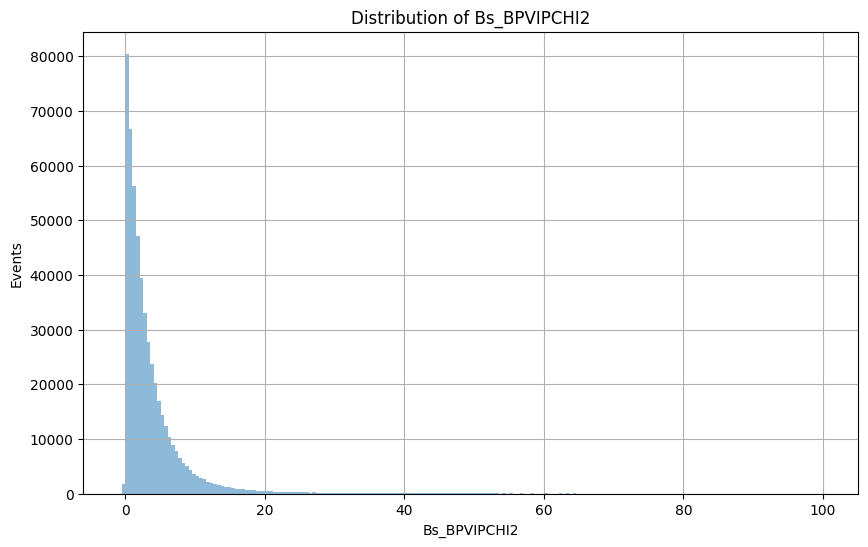

In [15]:
# BPVIPCHI2
plt.figure(figsize=(10, 6))
plt.hist(combined_df_mcdata['Bs_BPVIPCHI2'], bins=200, range=(-1,100), alpha=0.5)
plt.title("Distribution of Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel('Events')
plt.grid(True)
plt.show()

In [16]:
combined_df_mcdata = combined_df_mcdata[(combined_df_mcdata['Bs_BPVIPCHI2'] <= 30)]

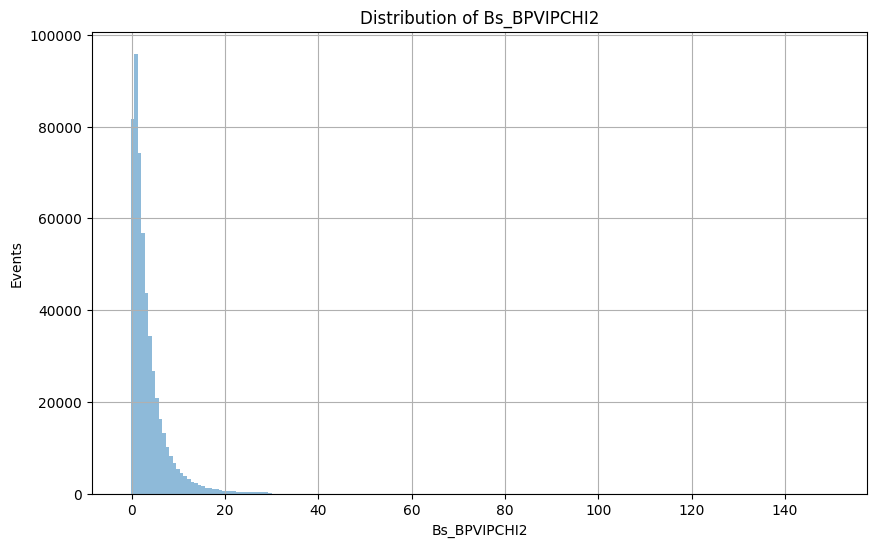

In [17]:
# BPVIPCHI2
plt.figure(figsize=(10, 6))
plt.hist(combined_df_mcdata['Bs_BPVIPCHI2'], bins=200, range=(-1,150), alpha=0.5)
plt.title("Distribution of Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel('Events')
plt.grid(True)
plt.show()

In [18]:
combined_df_mcdata

,Bs_DTF_PV_CTAU,Bs_DTF_PV_CTAUERR,RUNNUMBER,NPVs,Jpsi_M,Bs_ETA,Bs_PT,Bs_BPVZ,Bs_BPVIPCHI2,Bs_PZ,Bs_TRUE_LIFETIME,Bs_DTF_PV_TAUERR (ps),Bs_DTF_PV_TAU (ps),Cot_theta,T_Diff (ps)
0,0.978313,0.011338,22659218,6,3102.379395,3.742005,3843.782959,45.594799,1.781549,81025.976562,0.003211,0.037792,3.261045,21.079748,0.049658
1,0.085127,0.009722,22659218,3,3088.234375,2.587878,9091.705078,34.040600,1.064640,60128.980469,0.000273,0.032406,0.283756,6.613609,0.010560
2,0.087879,0.011226,22659218,3,3088.234375,2.587768,9092.756836,34.040600,0.852559,60129.160156,0.000273,0.037419,0.292931,6.612864,0.019736
3,1.091343,0.012058,22659218,6,3079.161621,4.873708,496.245514,37.144798,3.105215,32455.189453,0.003715,0.040192,3.637810,65.401474,-0.077209
4,0.258914,0.008388,22659218,4,3095.403564,2.746099,11590.852539,44.561298,0.971056,89935.273438,0.000901,0.027959,0.863048,7.759160,-0.038028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534285,0.146931,0.009169,22715396,8,3112.086182,3.387155,5954.478027,13.892300,3.323449,87979.203125,0.000482,0.030564,0.489771,14.775301,0.007728
534286,0.192358,0.006784,22715396,4,3102.965576,3.400936,7171.347656,-12.336500,3.604300,107432.390625,0.000667,0.022613,0.641195,14.980782,-0.026169
534287,0.705173,0.012304,22715396,5,3086.065430,2.664832,7323.576660,16.511200,0.601327,52353.828125,0.002288,0.041012,2.350575,7.148669,0.062382
534288,0.145367,0.006321,22715396,2,3097.513184,2.218192,28043.685547,17.539499,0.753727,127357.132812,0.000497,0.021071,0.484558,4.541384,-0.012875


In [19]:
"""
from ROOT import RooFit, RooRealVar, RooDataSet, RooGaussian, RooChebychev, RooVoigtian, RooAddPdf, RooArgList, RooArgSet
from ROOT import RooFit, RooRealVar, RooDataSet, RooGaussian, RooExponential, RooAddPdf, RooArgList, RooArgSet, RooStats


Jpsi_M = RooRealVar("Jpsi_M", "J/psi Mass", data_np.min(), data_np.max()) # x from 2950 to 3250

# Load the data into a RooDataSet (make sure dtree is your TTree with the data)
data = RooDataSet("data", "dataset with J/psi mass", combined_prompt, RooArgSet(Jpsi_M))

# Define the signal model (Gaussian)
mean = RooRealVar("mean", "mean of Voigtian", 3090, 3050, 3150)
sigma = RooRealVar("sigma", "sigma of gaussian", 20, 0.1, 40)   # Gaussian sigma
gauss = RooGaussian("gauss", "Gaussian Signal", Jpsi_M, mean, sigma)


# Define the background model (Exponential or Linear)
tau = RooRealVar("tau", "slope of background", -1.0, -5.0, 0)
expo = RooExponential("expo", "Exponential Background", Jpsi_M, tau)

# Define the combined model (Signal + Background)
nsig = RooRealVar("nsig", "number of signal events", 5000, 0, 50000)
nbkg = RooRealVar("nbkg", "number of background events", 50000, 0, 180000)
model = RooAddPdf("model", "signal + background", RooArgList(gauss, expo), RooArgList(nsig, nbkg))

# define PDF of signal and background 
model = RooAddPdf("model", "signal + background", RooArgList(gauss, expo), RooArgList(nsig, nbkg))

# fitting
model.fitTo(data)

canvas = ROOT.TCanvas("canvas", "J/psi Mass Fit", 800, 600)
frame = Jpsi_M.frame(RooFit.Title("J/psi Mass Distribution"))

# Plotting the data and its fitting line
data.plotOn(frame)
model.plotOn(frame)  # fitting line

# Plotting background line (red dash line)
model.plotOn(frame, RooFit.Components("expo"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kRed))

# Plotting signal line (green line)
model.plotOn(frame, RooFit.Components("gauss"), RooFit.LineStyle(ROOT.kSolid), RooFit.LineColor(ROOT.kGreen))

# Fitting parameters.
#param_box = model.paramOn(frame, RooFit.Layout(0.7, 0.9, 0.9))
#param_box.getAttText().SetTextSize(0.02)  

frame.Draw()
canvas.Draw()

# 11. Print the fit parameters (Signal mean, sigma, and event counts)
print(f"Signal Mean: {mean.getVal()} ± {mean.getError()}")
print(f"Signal Sigma: {sigma.getVal()} ± {sigma.getError()}")
print(f"Number of Signal Events: {nsig.getVal()} ± {nsig.getError()}")
"""

'\nfrom ROOT import RooFit, RooRealVar, RooDataSet, RooGaussian, RooChebychev, RooVoigtian, RooAddPdf, RooArgList, RooArgSet\nfrom ROOT import RooFit, RooRealVar, RooDataSet, RooGaussian, RooExponential, RooAddPdf, RooArgList, RooArgSet, RooStats\n\n\nJpsi_M = RooRealVar("Jpsi_M", "J/psi Mass", data_np.min(), data_np.max()) # x from 2950 to 3250\n\n# Load the data into a RooDataSet (make sure dtree is your TTree with the data)\ndata = RooDataSet("data", "dataset with J/psi mass", combined_prompt, RooArgSet(Jpsi_M))\n\n# Define the signal model (Gaussian)\nmean = RooRealVar("mean", "mean of Voigtian", 3090, 3050, 3150)\nsigma = RooRealVar("sigma", "sigma of gaussian", 20, 0.1, 40)   # Gaussian sigma\ngauss = RooGaussian("gauss", "Gaussian Signal", Jpsi_M, mean, sigma)\n\n\n# Define the background model (Exponential or Linear)\ntau = RooRealVar("tau", "slope of background", -1.0, -5.0, 0)\nexpo = RooExponential("expo", "Exponential Background", Jpsi_M, tau)\n\n# Define the combined model

In [20]:
"""
sData = RooStats.SPlot("sData", "sPlot", data, model, RooArgList(nsig, nbkg))
"""

'\nsData = RooStats.SPlot("sData", "sPlot", data, model, RooArgList(nsig, nbkg))\n'

In [21]:
"""
print(f"Signal Mean: {mean.getVal()} ± {mean.getError()}")
print(f"Signal Sigma: {sigma.getVal()} ± {sigma.getError()}")
print(f"Number of Signal Events: {nsig.getVal()} ± {nsig.getError()}")
print(f"Number of Background Events: {nbkg.getVal()} ± {nbkg.getError()}")

# print sWeight
print("The sWeights")
data.Print("v")  
"""

'\nprint(f"Signal Mean: {mean.getVal()} ± {mean.getError()}")\nprint(f"Signal Sigma: {sigma.getVal()} ± {sigma.getError()}")\nprint(f"Number of Signal Events: {nsig.getVal()} ± {nsig.getError()}")\nprint(f"Number of Background Events: {nbkg.getVal()} ± {nbkg.getError()}")\n\n# print sWeight\nprint("The sWeights")\ndata.Print("v")  \n'

In [22]:
"""
# acquire all entrence
n_entries = data.numEntries()
print(f"Number of entries: {n_entries}")

jpsi_m_values = []
nsig_sw_values = []
l_nsig_values = []
nbkg_sw_values = []
l_nbkg_values = []

# data extraction
for i in range(n_entries):
    # first table
    entry = data.get(i)
    
    # all observable
    jpsi_m = entry.getRealValue('Jpsi_M')
    nsig_sw = entry.getRealValue('nsig_sw')
    l_nsig = entry.getRealValue('L_nsig')
    nbkg_sw = entry.getRealValue('nbkg_sw')
    l_nbkg = entry.getRealValue('L_nbkg')
    
    # store in to list
    jpsi_m_values.append(jpsi_m)
    nsig_sw_values.append(nsig_sw)
    l_nsig_values.append(l_nsig)
    nbkg_sw_values.append(nbkg_sw)
    l_nbkg_values.append(l_nbkg)


print("First 5 entries for Jpsi_M:", jpsi_m_values[:5])
print("First 5 entries for nsig_sw:", nsig_sw_values[:5])
"""

'\n# acquire all entrence\nn_entries = data.numEntries()\nprint(f"Number of entries: {n_entries}")\n\njpsi_m_values = []\nnsig_sw_values = []\nl_nsig_values = []\nnbkg_sw_values = []\nl_nbkg_values = []\n\n# data extraction\nfor i in range(n_entries):\n    # first table\n    entry = data.get(i)\n    \n    # all observable\n    jpsi_m = entry.getRealValue(\'Jpsi_M\')\n    nsig_sw = entry.getRealValue(\'nsig_sw\')\n    l_nsig = entry.getRealValue(\'L_nsig\')\n    nbkg_sw = entry.getRealValue(\'nbkg_sw\')\n    l_nbkg = entry.getRealValue(\'L_nbkg\')\n    \n    # store in to list\n    jpsi_m_values.append(jpsi_m)\n    nsig_sw_values.append(nsig_sw)\n    l_nsig_values.append(l_nsig)\n    nbkg_sw_values.append(nbkg_sw)\n    l_nbkg_values.append(l_nbkg)\n\n\nprint("First 5 entries for Jpsi_M:", jpsi_m_values[:5])\nprint("First 5 entries for nsig_sw:", nsig_sw_values[:5])\n'

# Calibration Sigma

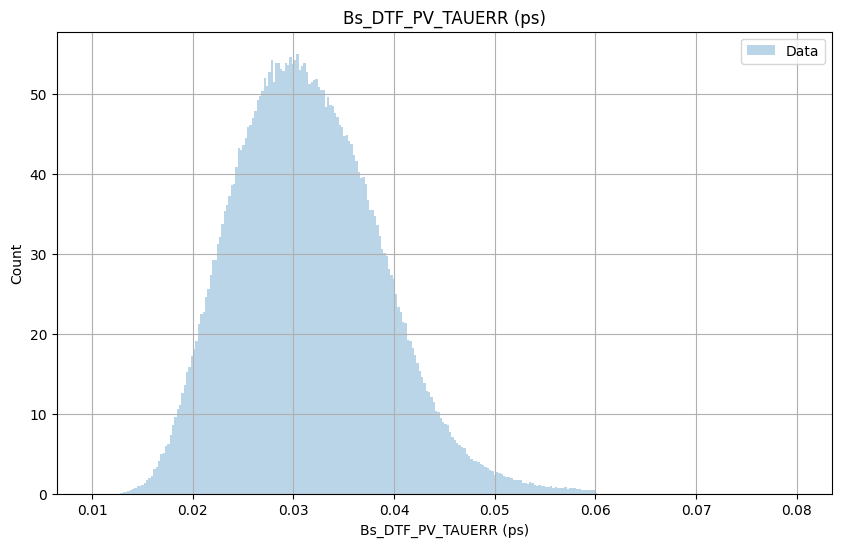

In [23]:
num= np.concatenate([np.round(np.linspace(0,0.05,10),4),np.round(np.linspace(0.051,0.25,25),4),
                     np.round(np.linspace(0.26,0.7,20),4),np.round(np.linspace(0.71,1,10),4)])

ini_cut = combined_df_mcdata[(combined_df_mcdata['Bs_DTF_PV_TAUERR (ps)'] > 0.013) & (combined_df_mcdata['Bs_DTF_PV_TAUERR (ps)'] < 0.06)]
Ctau_data = ini_cut['Bs_DTF_PV_TAUERR (ps)']
quantiles_mcdata = np.quantile(Ctau_data, num )

plt.figure(figsize=(10, 6))
plt.hist(Ctau_data  , bins=300, range=(0.01, 0.08), density=True, alpha=0.3, label='Data')
plt.title("Bs_DTF_PV_TAUERR (ps)")
plt.xlabel("Bs_DTF_PV_TAUERR (ps)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

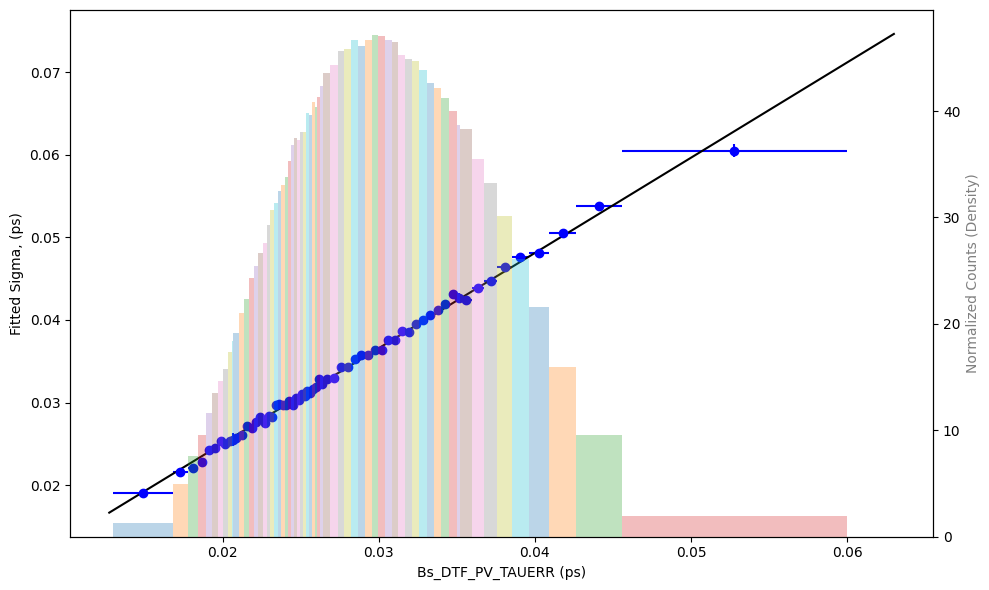

In [24]:
fitting_result_mcdata = quantiles_cutting_cal('Bs_DTF_PV_TAUERR (ps)','T_Diff (ps)',quantiles_mcdata, 
                                       combined_df_mcdata,cut_on_condata=[0.003, 0.07],cut_on_quantity = [-0.1,0.1]
                                         ,fitting_plots=False)

cali_sigma_mcdata = sig_vs_sig_t('Bs_DTF_PV_TAUERR (ps)','T_Diff (ps)',combined_df_mcdata,quantiles_mcdata,
                                 fitting_result_mcdata,y_unit='ps')

# selected_condition_quantity, filtered_quantity,combined_df, quantilesfitting_results,xyplot=False, x_unit=None, y_unit=None)

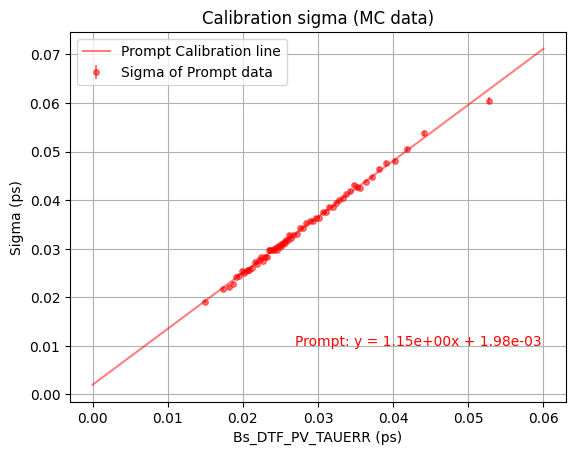

In [25]:
extended_x = np.linspace( 0, 0.06, 100) 
# extended_x = np.linspace(0, 0.01, 100)
fit_line_mcdata = np.polyval(cali_sigma_mcdata, extended_x)

# Plot the fitted lines
plt.plot(extended_x, fit_line_mcdata, color='r', linestyle='-',  alpha=0.5,label='Prompt Calibration line')
plt.errorbar(fitting_result_mcdata['mid_bin_point'],fitting_result_mcdata['sigma'], 
             yerr=fitting_result_mcdata['sigma_error'], markersize=4,alpha=0.5,fmt='o', color='red',label='Sigma of Prompt data')

# Extract the fit parameters for annotation
a_prompt, b_prompt = cali_sigma_mcdata

# Annotate the plot with the equations for each line
plt.text(0.027, 0.01, f'Prompt: y = {a_prompt:.2e}x + {b_prompt:.2e}', color='r', fontsize=10)

# Customize the plot
plt.title("Calibration sigma (MC data)")
plt.xlabel("Bs_DTF_PV_TAUERR (ps)")
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
#plt.ylim(0, 0.04)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


----

# Dilution Function

$$ D_{cali}=e^{-\frac{1}{2}\sigma_{cali}^2\Delta m_s^2} $$
$$ D_{eff} = \sqrt{\frac{1}{N}\sum D_{cali}^2}=\sqrt{\frac{1}{N}\sum{(e^{-\frac{1}{2}\sigma_{cali}^2\Delta m_s^2}})^2}$$
$$ \sigma_{eff}=\sqrt{-2ln(D_{eff})/\Delta m^2} $$

The t we use here is ctau

In [26]:
d_m_B_ps = 17.765 #ps-1, ps-1*J⋅s=J
d_m_B_mev = 1.1693 *(10**-8)*(10**6) # MeV

In [27]:
def calculate_exp_dilution_and_sigma(fit_params, sigma, d_m_B_ps):
    '''
    calculation of D_average (exp form) and D_eff 
    we are not using cos form.
    
    Note: Tauerr = uncali sigma
    
    return: D_average, D_eff, sigma_eff
    '''
    #  cali_sigma
    cali_sigma = np.polyval(fit_params, sigma)
    #  D_average
    D_average = np.sum(np.exp(-((cali_sigma * d_m_B_ps) ** 2) / 2)) / len(sigma)
    
    # D_tr 和 D_eff_mcdata
    D_tr = np.exp(-((cali_sigma * d_m_B_ps) ** 2) / 2)
    D_eff = np.sqrt(np.sum(D_tr ** 2) / len(sigma))
    
    print('D_cali:', D_average, '. Eff_D:', D_eff)
    
    # effective sigma
    sigma_eff = np.sqrt(-2 * np.log(D_eff) / (d_m_B_ps ** 2))
    print('Effective sigma:', sigma_eff, 'ps')
    
    return D_average, D_eff, sigma_eff

### Without S-Weight
$$D_{eff,mcdata} = \frac{1}{N}\sum_{all\ event}cos((t-t_{true}) * \Delta m_s)$$
$$D_{eff,prompt} = \frac{1}{N}\sum_{t<t-\mu}cos(t * \Delta m_s)$$
$$ \sigma_{eff}=\sqrt{-2ln(D_{eff})/\Delta m^2} $$

In [28]:
fitting_params_Generalprompt,_ = gaussfit_without_BG('T_Diff (ps)',combined_df_mcdata,[-0.1,0.1],plot=False)
# fitting_quantity, combined_df,cut_on_data,plot=False):

In [29]:
def calculate_cos_dilution (time,d_m_B_ps):

    D_eff = 1/len(time)*np.sum(np.cos(time*d_m_B_ps))
    
    sigma_eff = np.sqrt(-2 * np.log(D_eff) / (d_m_B_ps ** 2))

    return D_eff, sigma_eff 

In [30]:
def calculate_cos_dilution_sw (time,d_m_B_ps,sw):

    D_eff = np.sum(sw*np.cos(time*d_m_B_ps))/np.sum(sw)
    
    sigma_eff = np.sqrt(-2 * np.log(D_eff) / (d_m_B_ps ** 2))

    return D_eff, sigma_eff 

In [31]:
cut_df_c = combined_df_mcdata[(combined_df_mcdata['T_Diff (ps)'] <= fitting_params_Generalprompt['mean']['value'])]
cut_df_prompt = cut_df_c['T_Diff (ps)']-fitting_params_Generalprompt['mean']['value']
print('For prompt data, the effective dilution and effective are:')
print(calculate_cos_dilution(cut_df_prompt,d_m_B_ps))

For prompt data, the effective dilution and effective are:
(0.7683417830273688, 0.04086552508380831)


# Cuttting for $\sigma_{eff}$ (from $D_{eff}$) vs xxxx


## Uncertainty
$$ \sigma_{\sigma_{eff}}^2=\left(\frac{\partial \sigma_{eff}}{\partial D_{eff}} \right)^2 \sigma_D^2+\left(\frac{\partial \sigma_{eff}}{\partial \Delta m} \right)^2 \sigma_{\Delta m}^2$$
Since $\Delta m$ here is a constant, no error contribution, thus ignore the second term.
$$ \frac{\partial \sigma_{eff}}{\partial D_{eff}} = \frac{\partial}{\partial D_{eff}} \left( \sqrt{\frac{-2ln(D_{eff})}{\Delta m^2}} \right) = \frac{-1}{\sqrt{-2ln(D_{eff})\Delta m^2}}\cdot\frac{-2}{D_{eff}}\cdot\frac{1}{2}$$
$$ \frac{\partial \sigma_{eff}}{\partial D_{eff}} = \frac{1}{D_{eff}\sqrt{-2ln(D_{eff})\Delta m^2}}$$
$$ \sigma_{\sigma_{eff}}^2=\left(\frac{1}{D_{eff}\sqrt{-2ln(D_{eff})\Delta m^2}} \right)^2 \sigma_D^2 $$
$$ \sigma_{\sigma_{eff}}=\left(\frac{1}{D_{eff}\sqrt{-2ln(D_{eff})\Delta m^2}} \right) \sigma_D $$

### Uncertainty propagation without sweight
$$ \bar{var}(D_{eff})=\frac{1}{N-1}\sum_i(cos(\Delta mt)_i-\bar D_{eff})^2$$
with
$$ \sigma_{D}=\sqrt{\frac{\bar{var}(D_{eff})}{N}}$$

In [38]:
def array_sig_eff (data,time, d_m_B_ps, sw=False,):
    '''
    return: array of sigma_eff and D_eff
    '''
    
    results = {
        "D_eff": [],
        'sigma_eff':[],
        'sigma(D)':[],
        'sigma(sigma_eff)':[]
    }

    if sw is not False:
        for i in range(len(data)):
            result = calculate_cos_dilution_sw(data[i][time],d_m_B_ps,data[i]['nsig_weights'])
            results["D_eff"].append(result[0])
            results['sigma_eff'].append(result[1])
            # variance  of D_eff

            var = 1/np.sum(data[i]['nsig_weights']) * np.sum( (data[i]['nsig_weights'] *( np.cos(data[i][time]*d_m_B_ps) - result[0]) )** 2 )
            
            sigma_D = np.sqrt(var/np.sum(data[i]['nsig_weights']))
            
            # error propagation
            sigma_sigma_eff = (1/ (result[0] * np.sqrt(-2 * np.log(result[0]) * (d_m_B_ps**2))) ) * sigma_D
            
            results['sigma(D)'].append(sigma_D)
            results['sigma(sigma_eff)'].append(sigma_sigma_eff)
            
    else:
        for i in range(len(data[time])):
                
            result = calculate_cos_dilution(data[time][i],d_m_B_ps)
            results["D_eff"].append(result[0])
            results['sigma_eff'].append(result[1])
            # variance  of D_eff

            var = 1/len(data[time][i]) * np.sum((np.cos(data[time][i]*d_m_B_ps)-result[0])**2)
            sigma_D = np.sqrt(var/len(data[time][i]))
            # error propagation
            sigma_sigma_eff = (1/ (result[0] * np.sqrt(-2 * np.log(result[0]) * (d_m_B_ps**2))) )*sigma_D 
            results['sigma(D)'].append(sigma_D)
            results['sigma(sigma_eff)'].append(sigma_sigma_eff)
        

    
    return results
    

In [33]:
cut_df_c.loc[:, 'shifted_T_Diff (ps)'] = cut_df_c['T_Diff (ps)'] - fitting_params_Generalprompt['mean']['value']

/var/folders/lg/sm4b58wn6gn_45ytw5wczs8h0000gn/T/ipykernel_85087/3296635570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_df_c.loc[:, 'shifted_T_Diff (ps)'] = cut_df_c['T_Diff (ps)'] - fitting_params_Generalprompt['mean']['value']


In [34]:
cut_df_c

,Bs_DTF_PV_CTAU,Bs_DTF_PV_CTAUERR,RUNNUMBER,NPVs,Jpsi_M,Bs_ETA,Bs_PT,Bs_BPVZ,Bs_BPVIPCHI2,Bs_PZ,Bs_TRUE_LIFETIME,Bs_DTF_PV_TAUERR (ps),Bs_DTF_PV_TAU (ps),Cot_theta,T_Diff (ps),shifted_T_Diff (ps)
3,1.091343,0.012058,22659218,6,3079.161621,4.873708,496.245514,37.144798,3.105215,32455.189453,0.003715,0.040192,3.637810,65.401474,-0.077209,-0.076053
4,0.258914,0.008388,22659218,4,3095.403564,2.746099,11590.852539,44.561298,0.971056,89935.273438,0.000901,0.027959,0.863048,7.759160,-0.038028,-0.036872
7,0.561554,0.008727,22659218,8,3102.504639,3.287241,4181.135742,-77.849602,0.947357,55888.128906,0.001884,0.029088,1.871847,13.366734,-0.011842,-0.010686
8,0.178866,0.010436,22659218,4,3087.402588,2.988320,5480.886719,-38.676399,4.233104,54268.640625,0.000607,0.034787,0.596219,9.901435,-0.010904,-0.009747
14,1.004290,0.008375,22659218,1,3097.784912,3.204259,6885.703613,-43.768501,2.434763,84683.906250,0.003363,0.027916,3.347635,12.298512,-0.014989,-0.013833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534278,2.238258,0.013677,22715396,6,3110.307861,3.496879,3600.500244,-38.309399,4.989733,59379.011719,0.007463,0.045591,7.460859,16.491879,-0.002291,-0.001135
534279,0.629731,0.009540,22715396,8,3095.959961,3.856741,5683.726074,100.733200,4.168538,134391.515625,0.002113,0.031802,2.099102,23.644966,-0.014312,-0.013155
534284,0.825043,0.010852,22715396,4,3096.178223,5.573972,949.529419,42.446899,2.842815,125095.562500,0.002795,0.036173,2.750143,131.744797,-0.045248,-0.044092
534286,0.192358,0.006784,22715396,4,3102.965576,3.400936,7171.347656,-12.336500,3.604300,107432.390625,0.000667,0.022613,0.641195,14.980782,-0.026169,-0.025013


# Sigma vs PT/ETA

### Un-sweighted plot

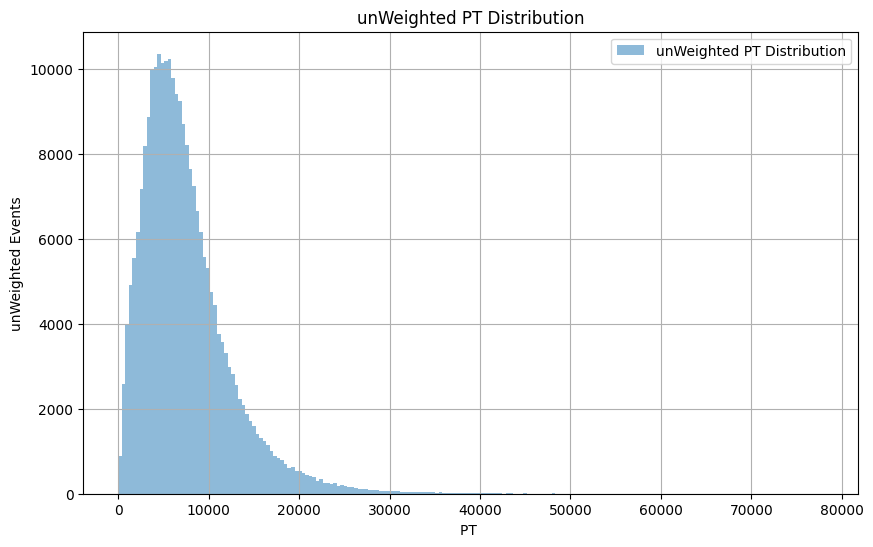

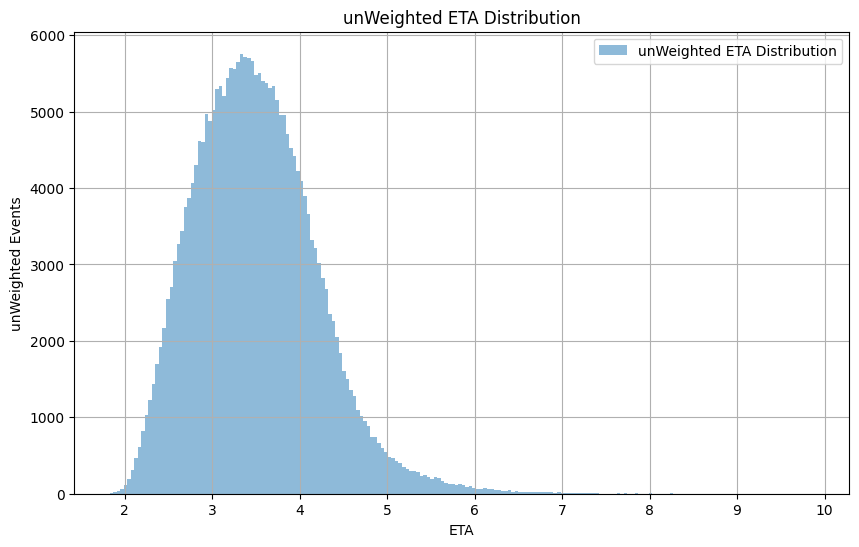

In [35]:
# PT
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['Bs_PT'], bins=200, alpha=0.5, label='unWeighted PT Distribution')
plt.title('unWeighted PT Distribution')
plt.xlabel('PT ')
plt.ylabel('unWeighted Events')
plt.legend()
plt.grid(True)
plt.show()

# ETA
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['Bs_ETA'], bins=200, alpha=0.5, label='unWeighted ETA Distribution')
plt.title('unWeighted ETA Distribution')
plt.xlabel('ETA')
plt.ylabel('unWeighted Events')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
num = np.linspace(0,1,20)

ini_cut_ETA = cut_df_c[(cut_df_c['Bs_ETA'] > 2) & (cut_df_c['Bs_ETA'] < 8)]
quantiles_ETA_mcdata = np.quantile(ini_cut_ETA['Bs_ETA'], num)
cutting_ETA = quantiles_cutting_data ('Bs_ETA', 'shifted_T_Diff (ps)', 
                                         cut_df_c,quantiles_ETA_mcdata,[2,8],[-100,100],nbin=500)
sig_eff_ETA = array_sig_eff(cutting_ETA,'cut_data',d_m_B_ps,sw=False)

ini_cut_PT = cut_df_c[(cut_df_c['Bs_PT'] > 0) & (cut_df_c['Bs_PT'] < 12500)]
quantiles_PT_mcdata = np.quantile(ini_cut_PT['Bs_PT'], num)
cutting_PT = quantiles_cutting_data ('Bs_PT', 'shifted_T_Diff (ps)', 
                                         cut_df_c,quantiles_PT_mcdata,[0,12500],[-100,100],nbin=500)
sig_eff_PT = array_sig_eff(cutting_PT,'cut_data',d_m_B_ps,sw=False)

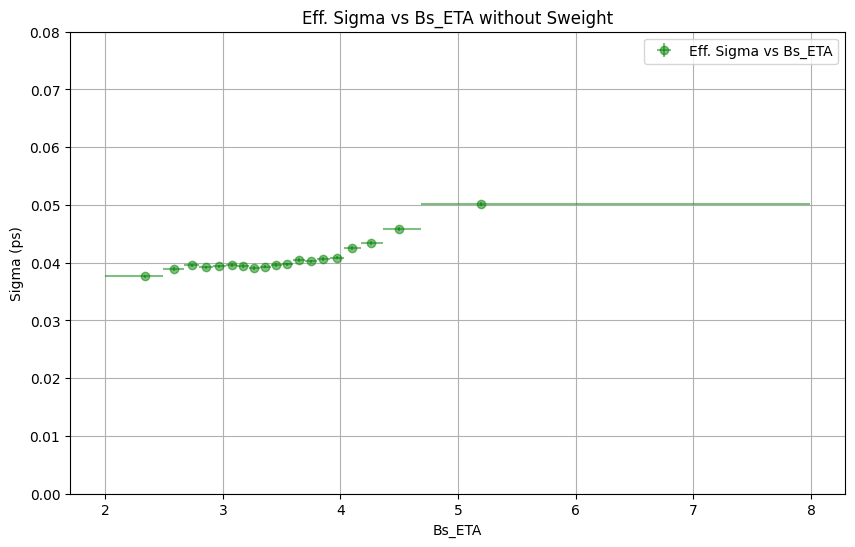

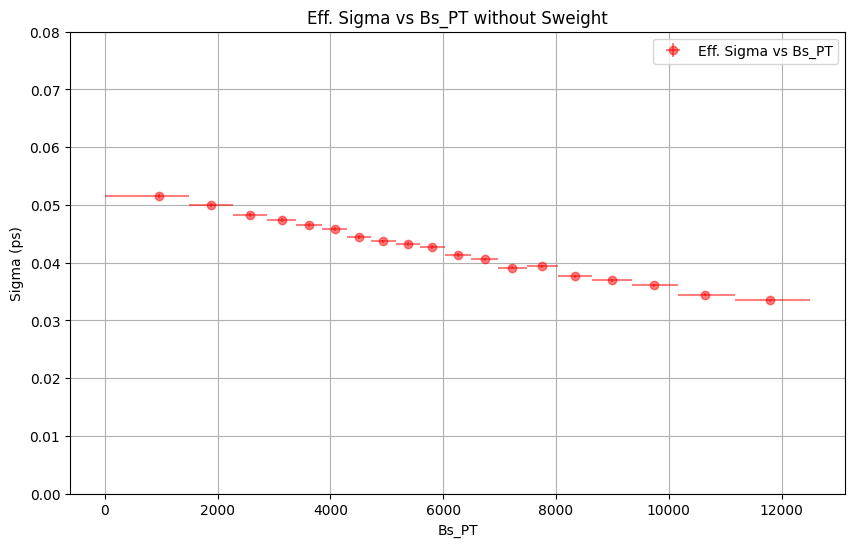

In [40]:
neg_xerr_eff_ETA = np.array(cutting_ETA['width_bar']) - \
                  (np.array(cutting_ETA["mid_bin_point"]) - np.array(cutting_ETA["average_point"])) 

pos_xerr_eff_ETA = np.array(cutting_ETA['width_bar']) + \
                  (np.array(cutting_ETA["mid_bin_point"]) - np.array(cutting_ETA["average_point"])) 


# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(cutting_ETA["average_point"],sig_eff_ETA['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_ETA,pos_xerr_eff_ETA],yerr=sig_eff_ETA['sigma(sigma_eff)'], label = "Eff. Sigma vs Bs_ETA")

# Customize the plot
plt.title("Eff. Sigma vs Bs_ETA without Sweight")
plt.xlabel('Bs_ETA')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0.0, 0.08)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


neg_xerr_eff_PT = np.array(cutting_PT['width_bar']) - \
                 (np.array(cutting_PT["mid_bin_point"]) - np.array(cutting_PT["average_point"])) 
pos_xerr_eff_PT = np.array(cutting_PT['width_bar']) + \
                 (np.array(cutting_PT["mid_bin_point"]) - np.array(cutting_PT["average_point"])) 

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(cutting_PT["average_point"],sig_eff_PT['sigma_eff'] ,alpha=0.5, fmt='o', color='red',
             xerr=[neg_xerr_eff_PT,pos_xerr_eff_PT],yerr=sig_eff_PT['sigma(sigma_eff)'],label = "Eff. Sigma vs Bs_PT")

# Customize the plot
plt.title("Eff. Sigma vs Bs_PT without Sweight")
plt.xlabel('Bs_PT')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0.0, 0.08)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Rec. Sigma without Sweight
$$ D_{T_{diff}}=e^{-\frac{1}{2}\sigma_{T_{diff}}^2\Delta m_s^2} $$
$$ < D_{rec} ^2> = \frac{\sum D_{T_{diff}}^2}{N}$$
$$  D_{rec}  =\sqrt{< D_{rec} ^2>}= \sqrt{\frac{\sum D_{Rec}^2}{N}}\quad\quad (RMS)$$
$$ \sigma_{rec}=\sqrt{-2ln(D_{rec})/\Delta m^2} $$

The sigma we use here is T_diff
### Uncertainty propagation without sweight
$$ \sigma_{\sigma_{rec}}=\left(\frac{1}{D_{rec}\sqrt{-2ln(D_{rec})\Delta m^2}} \right) \sigma_{D_{rec}} $$
$$ var(<D_{rec}^2>) \simeq \frac{1}{N^2}  \sum_{event}(<D_{rec}^2> -  D_{T_{diff},i}^2)^2$$
with
$$ \sigma_{D^2}=\sqrt{var(D_{rec}^2) }$$
$$ \sigma_{D_{rec}}=\frac{1}{2\sqrt{<D^2_{rec}>}}\sigma_{D^2}$$


In [41]:
def rec_sigma (data,d_m_B_ps):
    '''

    return: array of sigma_rec and Drec
    '''
    
    results = {
        "D_rec": [],
        'sigma_rec':[],
        'sigma(D)':[],
        'sigma(sigma_rec)':[]
    }

    #  D_tauerr
    for i in range(len(data)):
        
        
        # rec sigma
        
        D = np.exp(-((data[i] * d_m_B_ps) ** 2) / 2) 
        D_2 = np.sum( (D ** 2)) / np.sum(len(data[i]))
        D_rec = np.sqrt( D_2 )
        var_D2 = 1 / (len(data[i])**2) * np.sum( (D_2 - D**2 )**2)
        
        sigma_rec = np.sqrt(-2 * np.log(D_rec) / (d_m_B_ps ** 2)) 
        sigma_D2 = np.sqrt(var_D2 )
        sigma_D = 1/(2*np.sqrt(D_2)) * sigma_D2
        sigma_sigma_rec = (1/ (D_rec  * np.sqrt(-2 * np.log(D_rec) * (d_m_B_ps**2))) )*sigma_D
        
        results["D_rec"].append(D_rec)
        results['sigma_rec'].append(sigma_rec)        
        results['sigma(D)'].append(sigma_D)
        results['sigma(sigma_rec)'].append(sigma_sigma_rec)
        
    return results

In [42]:
num = np.linspace(0,1,20)
#ETA
ini_cut_ETA = cut_df_c[(cut_df_c['Bs_ETA'] > 2) & (cut_df_c['Bs_ETA'] < 8)]
quantiles_ETA_mcdata = np.quantile(ini_cut_ETA['Bs_ETA'], num)
rec_cutting_ETA = quantiles_cutting_data ('Bs_ETA', 'shifted_T_Diff (ps)',
                                         ini_cut_ETA,quantiles_ETA_mcdata,[2,8],[-100,100],nbin=500)
rec_sig_ETA =rec_sigma(rec_cutting_ETA['cut_data'],d_m_B_ps)

# PT
ini_cut_PT = cut_df_c[(cut_df_c['Bs_PT'] > 0) & (cut_df_c['Bs_PT'] < 12500)]
quantiles_PT_mcdata = np.quantile(ini_cut_PT['Bs_PT'], num)
rec_cutting_PT = quantiles_cutting_data('Bs_PT', 'shifted_T_Diff (ps)',
                                         ini_cut_PT,quantiles_PT_mcdata,[2,8],[-100,100],nbin=500)
rec_sig_PT = rec_sigma(rec_cutting_PT['cut_data'],d_m_B_ps)

#for i in range(len(cali_cutting_PT['cut_data'])):
 #   cali_cutting_PT['cut_data'][i]['cali_sigma'] = np.polyval(cali_sigma_prompt, uncali_cutting_PT['cut_data'][i]['Bs_DTF_PV_TAUERR (ps)'])

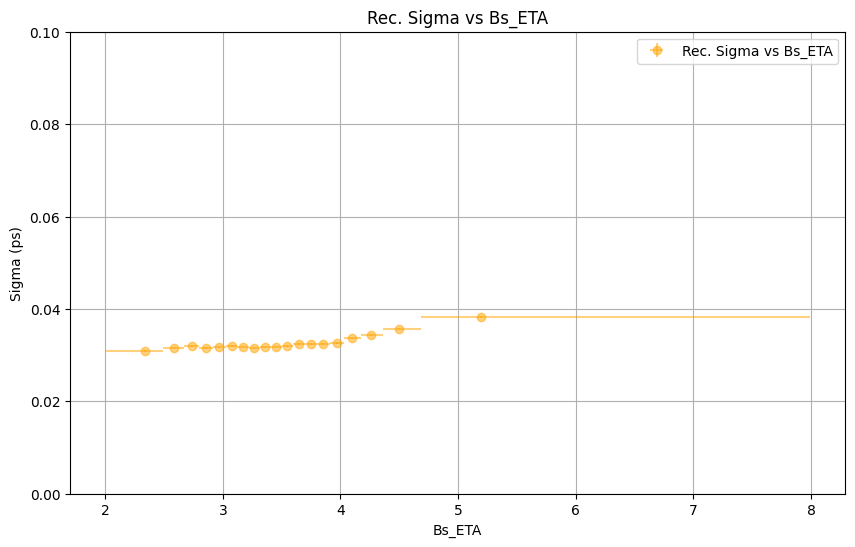

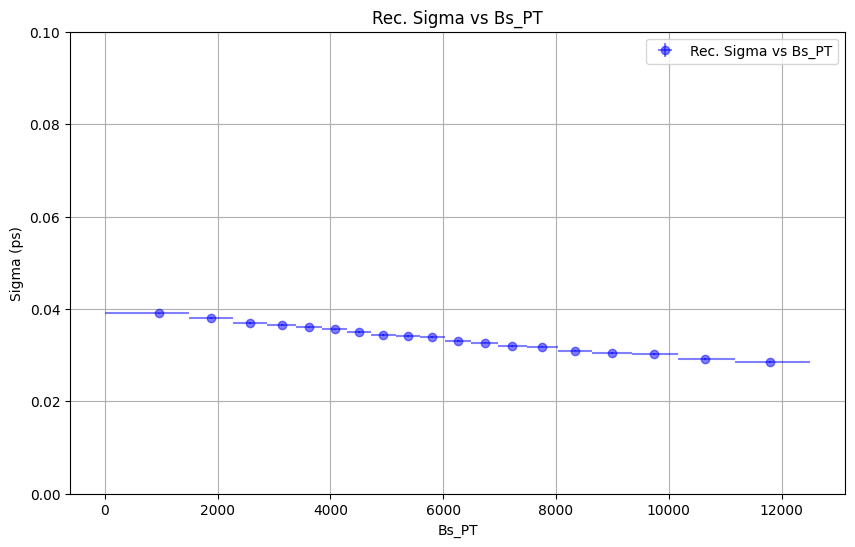

In [46]:
# Plot the fitted lines
neg_xerr_rec_ETA = np.array(rec_cutting_ETA['width_bar']) - \
                  (np.array(rec_cutting_ETA["mid_bin_point"]) - np.array(rec_cutting_ETA["average_point"])) 

pos_xerr_rec_ETA = np.array(rec_cutting_ETA['width_bar']) + \
                  (np.array(rec_cutting_ETA["mid_bin_point"]) - np.array(rec_cutting_ETA["average_point"])) 

plt.figure(figsize=(10, 6))
plt.errorbar(rec_cutting_ETA['average_point'],rec_sig_ETA['sigma_rec'] ,alpha=0.5, fmt='o', color='orange',
              xerr=[neg_xerr_rec_ETA,pos_xerr_rec_ETA],yerr=rec_sig_ETA['sigma(sigma_rec)'] ,label = "Rec. Sigma vs Bs_ETA")

# Customize the plot
plt.title("Rec. Sigma vs Bs_ETA")
plt.xlabel('Bs_ETA')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


# Plot the fitted lines
neg_xerr_rec_PT = np.array(rec_cutting_PT['width_bar']) - \
                  (np.array(rec_cutting_PT["mid_bin_point"]) - np.array(rec_cutting_PT["average_point"])) 

pos_xerr_rec_PT = np.array(rec_cutting_PT['width_bar']) + \
                  (np.array(rec_cutting_PT["mid_bin_point"]) - np.array(rec_cutting_PT["average_point"])) 

plt.figure(figsize=(10, 6))
plt.errorbar(rec_cutting_PT['average_point'],rec_sig_PT['sigma_rec'] ,alpha=0.5, fmt='o', color='blue',
             xerr=[neg_xerr_rec_PT,pos_xerr_rec_PT],yerr=rec_sig_ETA['sigma(sigma_rec)'],label = "Rec. Sigma vs Bs_PT")

# Customize the plot
plt.title("Rec. Sigma vs Bs_PT")
plt.xlabel('Bs_PT')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


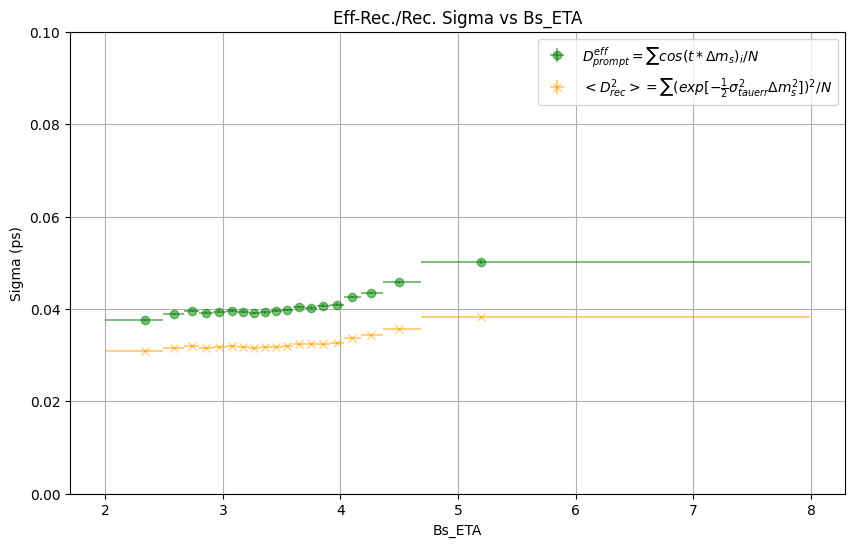

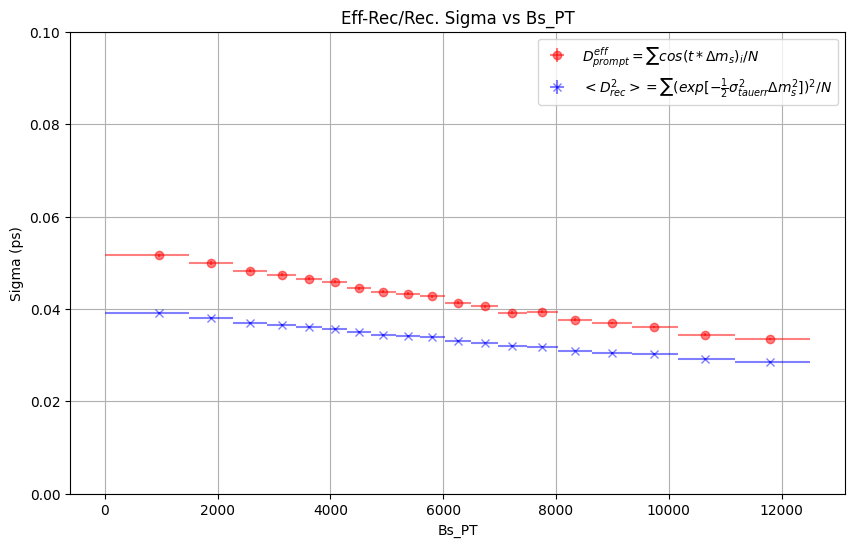

In [48]:
# Plot the fitted lines
plt.figure(figsize=(10, 6))
plt.errorbar(cutting_ETA["average_point"],sig_eff_ETA['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_ETA,pos_xerr_eff_ETA],yerr=sig_eff_ETA['sigma(sigma_eff)'],
             label = r"$D_{prompt}^{eff} = \sum cos(t * \Delta m_s)_i / N$")

plt.errorbar(rec_cutting_ETA['average_point'],rec_sig_ETA['sigma_rec'] ,alpha=0.5, fmt='x', color='orange',
             xerr=[neg_xerr_rec_ETA,pos_xerr_rec_ETA],yerr=rec_sig_ETA['sigma(sigma_rec)'],
             label = r"$< D_{rec} ^2> = \sum (exp[-\frac{1}{2}\sigma_{T_{diff}}^2\Delta m_s^2])^2 / N $")
# yerr=cali_sig_eff_ETA_sw['sigma(sigma_eff)'], 
# Customize the plot
plt.title("Eff-Rec./Rec. Sigma vs Bs_ETA")
plt.xlabel('Bs_ETA')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(cutting_PT["average_point"],sig_eff_PT['sigma_eff'] ,alpha=0.5, fmt='o', color='red',
             xerr=[neg_xerr_eff_PT,pos_xerr_eff_PT],yerr=sig_eff_PT['sigma(sigma_eff)'],
             label = r"$D_{prompt}^{eff} = \sum cos(t * \Delta m_s)_i / N$")
             
plt.errorbar(rec_cutting_PT['average_point'],rec_sig_PT['sigma_rec'] ,alpha=0.5, fmt='x', color='blue',
               xerr=[neg_xerr_rec_PT,pos_xerr_rec_PT],yerr=rec_sig_PT['sigma(sigma_rec)'],
             label = r"$< D_{rec} ^2> = \sum (exp[-\frac{1}{2}\sigma_{T_{diff}}^2\Delta m_s^2])^2 / N $")

# Customize the plot
plt.title("Eff-Rec/Rec. Sigma vs Bs_PT")
plt.xlabel('Bs_PT')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

## Cali_sigma/Rec_sigma vs ETA
$$ R=\frac{\sigma_{rec}^{eff}}{\sigma_{rec}} $$
#### Error propagation
$$ \sigma_R=R*\sqrt{\left(\frac{\sigma_{\sigma_{eff}}}{\sigma_{eff}}\right)^2+\left(\frac{\sigma_{\sigma_{rec}}}{\sigma_{rec}}\right)^2} $$

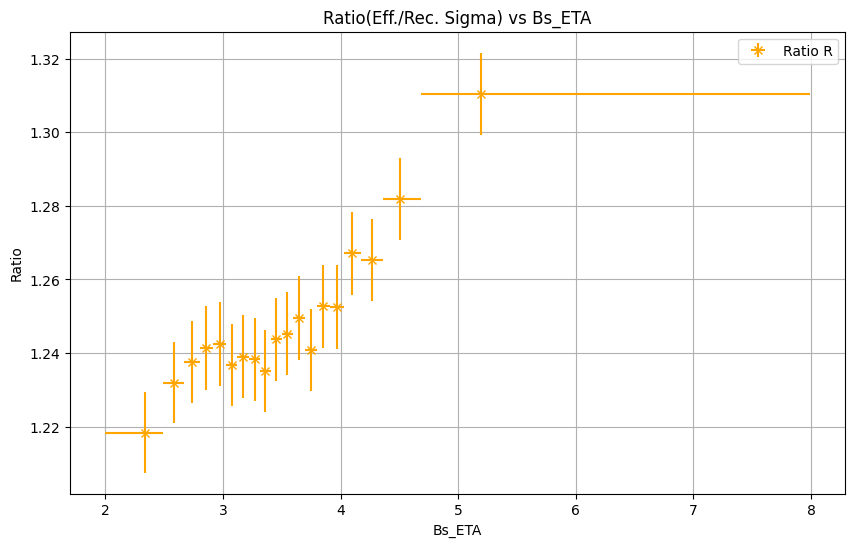

In [49]:
R = np.array(sig_eff_ETA['sigma_eff'])/np.array(rec_sig_ETA['sigma_rec'])
#sigma_r = R * np.sqrt((np.array(uncali_sig_eff_ETA_sw['sigma(sigma_eff)'])/ np.array(uncali_sig_eff_ETA_sw['sigma_eff']))**2 + 
#                      (np.array(rec_sig_eff_ETA_sw['sigma(sigma_eff)']) / np.array(rec_sig_eff_ETA_sw['sigma_eff']))**2)

sigma_R_ETA = R * np.sqrt( (np.array(sig_eff_ETA['sigma(sigma_eff)'])/np.array(sig_eff_ETA['sigma_eff']))**2 
        + (np.array(rec_sig_ETA['sigma(sigma_rec)'])/np.array(rec_sig_ETA['sigma_rec']))**2 )

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(rec_cutting_ETA['average_point'],R, yerr = sigma_R_ETA, xerr=[neg_xerr_eff_ETA,pos_xerr_eff_ETA],
              fmt='x', color='orange',
             label = "Ratio R")

# Customize the plot
plt.title("Ratio(Eff./Rec. Sigma) vs Bs_ETA")
plt.xlabel('Bs_ETA')
plt.ylabel("Ratio")
#plt.xlim(0, 0.011)
#plt.ylim(0.045, 0.08)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

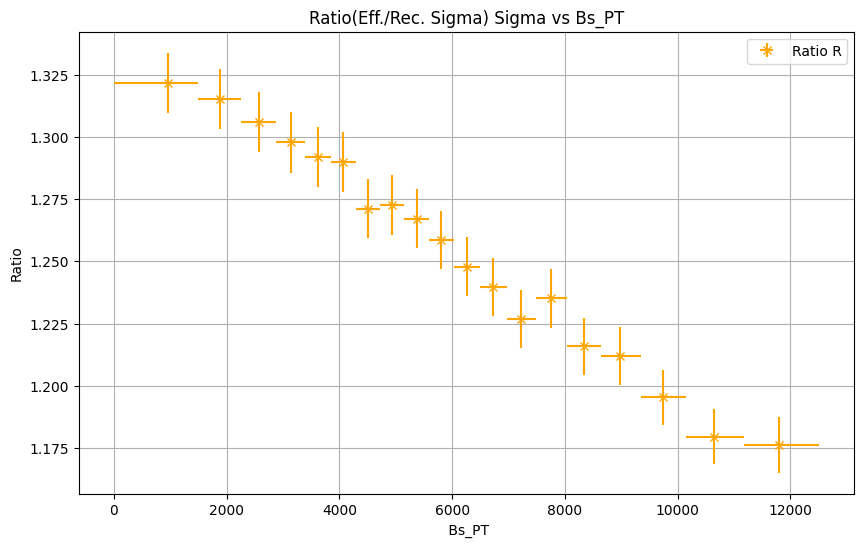

In [50]:
R = np.array(sig_eff_PT['sigma_eff'])/np.array(rec_sig_PT['sigma_rec'])
#sigma_r = R * np.sqrt((np.array(uncali_sig_eff_ETA_sw['sigma(sigma_eff)'])/ np.array(uncali_sig_eff_ETA_sw['sigma_eff']))**2 + 
#                      (np.array(rec_sig_eff_ETA_sw['sigma(sigma_eff)']) / np.array(rec_sig_eff_ETA_sw['sigma_eff']))**2)

sigma_R_PT = R * np.sqrt( (np.array(sig_eff_PT['sigma(sigma_eff)'])/np.array(sig_eff_PT['sigma_eff']))**2 
        + (np.array(rec_sig_PT['sigma(sigma_rec)'])/np.array(rec_sig_PT['sigma_rec']))**2 )

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(rec_cutting_PT['average_point'],R,xerr=[neg_xerr_eff_PT,pos_xerr_eff_PT], yerr = sigma_R_PT, 
              fmt='x', color='orange',
             label = "Ratio R")

# Customize the plot
plt.title("Ratio(Eff./Rec. Sigma) Sigma vs Bs_PT")
plt.xlabel(' Bs_PT')
plt.ylabel("Ratio")
#plt.xlim(0, 0.011)
#plt.ylim(0.045, 0.08)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

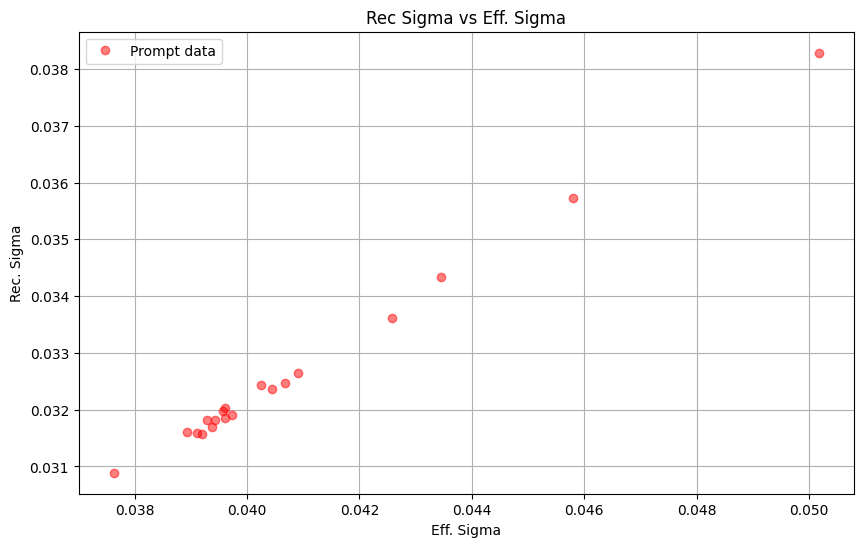

In [51]:

# Plot the fitted lines
plt.figure(figsize=(10, 6))
plt.errorbar(sig_eff_ETA['sigma_eff'] ,rec_sig_ETA['sigma_rec'],alpha=0.5, fmt='o', color='red',label = "Prompt data")

# Customize the plot
plt.title("Rec Sigma vs Eff. Sigma" )
plt.xlabel('Eff. Sigma')
plt.ylabel("Rec. Sigma")
#plt.xlim(0, 0.1)
#plt.ylim(0., 0.1)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Tail fraction
$$ f_i=\frac{N_{tot}-N_{gauss}}{N_{tot}} $$

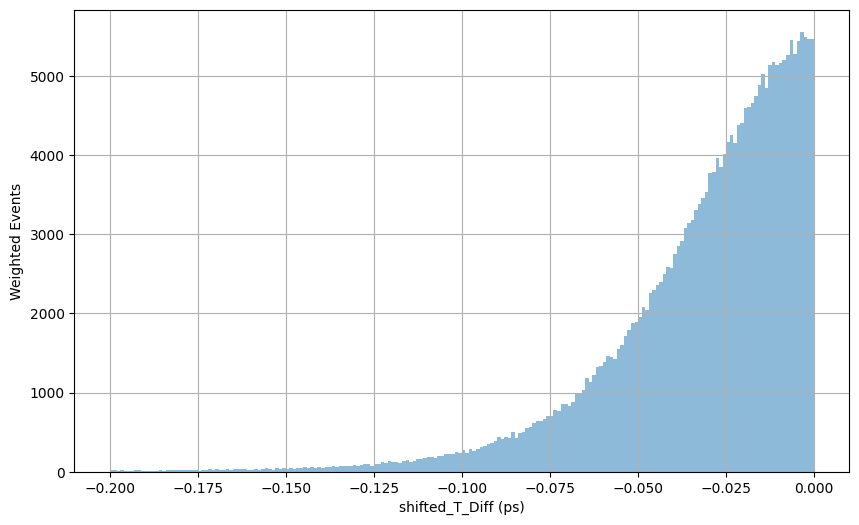

In [52]:
# PT
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['shifted_T_Diff (ps)'], bins=200,range=(-0.2,0), alpha=0.5)
plt.xlabel('shifted_T_Diff (ps)')
plt.ylabel('Weighted Events')
plt.grid(True)
plt.show()

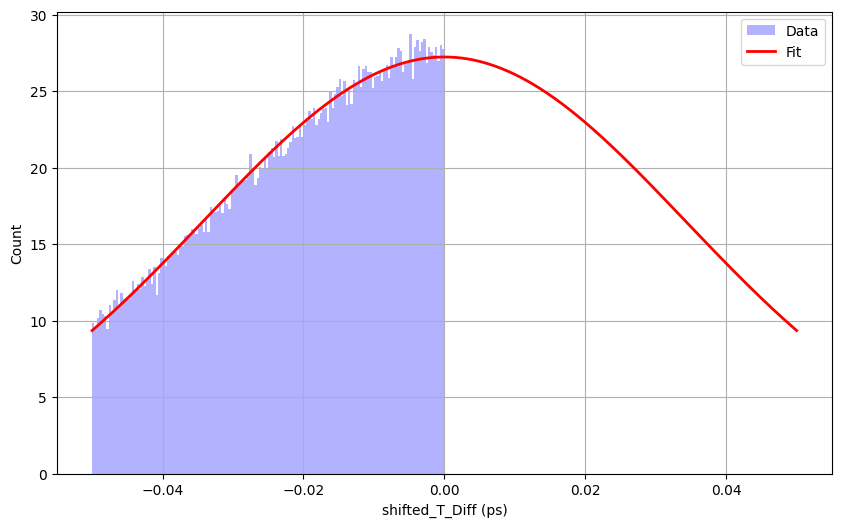

In [53]:
fitting_params_Generalprompt,N_sel = gaussfit_without_BG('shifted_T_Diff (ps)',
                                                   cut_df_c,[-0.05,0.05],plot=True,mean=[0],zfit_spc_lim=[-0.05,0])
# fitting_quantity, combined_df,cut_on_data,plot=False):

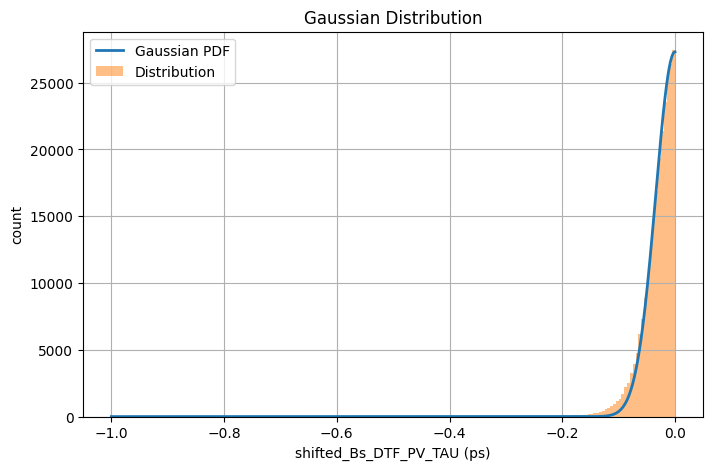

In [54]:
# Define the observable space
obs = zfit.Space('x', limits=(-0.2, 0))

# Define parameters
mu = 0  # assuming mean is zero for demonstration
sigma = fitting_params_Generalprompt['sigma']['value']

# Create the Gaussian PDF
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)

# Create x-values over which to calculate the PDF
x_values = np.linspace(-1, 0, num=1000)
pdf_values = gauss.pdf(x_values).numpy()*1170

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x_values, pdf_values, label='Gaussian PDF', linewidth=2)
plt.hist(cut_df_c['shifted_T_Diff (ps)'], bins=200,  range=(-1, 0), alpha=0.5, label='Distribution')
plt.title('Gaussian Distribution')
plt.xlabel('shifted_Bs_DTF_PV_TAU (ps)')
plt.ylabel('count')
plt.legend()
plt.grid(True)
plt.show()


### 1 $\sigma$ ~ 68.27%

In [55]:
one_sigma = cut_df_c[(cut_df_c['shifted_T_Diff (ps)'] > -fitting_params_Generalprompt['sigma']['value']) ]

In [56]:
len(one_sigma)

157791

### $N_{gauss}$

In [57]:
np.round(len(one_sigma)/0.6827)

231128.0

#### $N_{Tail}$

In [58]:
(len(cut_df_c)-np.round(len(one_sigma)/0.6827))

17301.0

#### $f_i=\frac{N_{tot}-N_{gauss}}{N_{tot}}$

In [59]:
(len(cut_df_c)-np.round(len(one_sigma)/0.6827))/len(cut_df_c)

0.06964162799029099

### Error function
$$erf(z)=\frac{1}{\sqrt{\pi}}\int^z_0 e^{-t^2}dt$$
$$ \frac{d}{dz}erf(z)=\frac{2}{\sqrt{\pi}}e^{-z^2}$$
that is normally distributed with mean 0 and standard deviation 1/2.
$$ G(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

For Gaussian:
$$I(G(x))=\frac{1}{\sqrt{2\pi\sigma^2}}\int^x_0 e^{-\left(\frac{x'-\mu}{\sqrt{2}\sigma}\right)^2}dx'$$
In our case $\mu=0$

### $N_{gauss}$

$$\frac{N_{gauss}}{N_{sel}}=\frac{\int^0_{-\infty} e^{-\left(\frac{x'}{\sqrt{2}\sigma}\right)^2dx}}{\int^{0}_{-0.05}e^{-\left(\frac{x'}{\sqrt{2}\sigma}\right)^2dx}}$$

In [60]:
from scipy.integrate import quad
from scipy.stats import norm

sigma_tot = fitting_params_Generalprompt['sigma']['value']

def gaussian(x,sigma_value):
    return 1/np.sqrt(2*np.pi*sigma_value**2)*np.exp(-x**2 / (2 * sigma_value**2))

# -infinity to 0
integral1, _ = quad(lambda x: gaussian(x, sigma_tot), 0 ,-0.4)
#  0 to -0.05
integral2, _ = quad(lambda x: gaussian(x, sigma_tot), 0, -0.05)

N_gauss = N_sel*integral1/integral2
print(N_gauss)

231397.70063046468


### $N_{tail}$

In [61]:
N_tot = len(cut_df_c)
N_tail = (N_tot-N_gauss )
N_tail

17031.29936953532

#### $f_{tail}=\frac{N_{tot}-N_{gauss}}{N_{tot}}$

In [62]:
frac_tail = (N_tot -  N_gauss )/N_tot
frac_tail

0.06855600340352906

In [63]:
def f_tail_cal (cut,sigma,N_select,N_tot):
    
    N_event = {
        'frac_tail':[],
        "N_gauss": [],
        "N_tail": []
    }

    for i in range(len(sigma)):
        
        integral1, _ = quad(lambda x: gaussian(x, sigma[i]), cut[0] , - np.inf)
        integral2, _ = quad(lambda x: gaussian(x, sigma[i]), cut[0], cut[1])

        N_gauss = N_select*integral1/integral2
        N_tail = (N_tot-N_gauss)
        frac_tail = (N_tot -  N_gauss )/N_tot

        N_event['frac_tail'].append(frac_tail)
        N_event["N_gauss"].append(N_gauss)
        N_event["N_tail"].append(N_tail)
    
    
    return N_event
    

## $f_{tail}$ v.s. $\eta$

In [64]:
num = np.linspace(0,1,20)
# ETA
ini_cut_ETA = cut_df_c[(cut_df_c['Bs_ETA'] > 2) & (cut_df_c['Bs_ETA'] < 8)]
quantiles_ETA_prompt = np.quantile(ini_cut_ETA['Bs_ETA'], num)
N_event_ETA_data = quantiles_cutting_data ('Bs_ETA', ['shifted_T_Diff (ps)','Bs_ETA'],
                                         ini_cut_ETA,quantiles_ETA_prompt,[2,8],[-100,100],nbin=500)

In [65]:
N_event_prompt = []
for i in range (len(N_event_ETA_data['cut_data'])):
    
    fitting_params_Generalprompt,N_sel = gaussfit_without_BG('shifted_T_Diff (ps)',N_event_ETA_data['cut_data'][i],
                                                             [-0.1,0.1],plot=False,mean=[0],zfit_spc_lim=[-0.1,0])
    N_tot = len(N_event_ETA_data['cut_data'][i])
    
#    print(fitting_params_Generalprompt['sigma']['value'],N_sel)
    N = f_tail_cal([0,-0.1],[fitting_params_Generalprompt['sigma']['value']],N_sel,N_tot)
#    print(N["frac_tail"])

    N_event_prompt.append(N["frac_tail"])


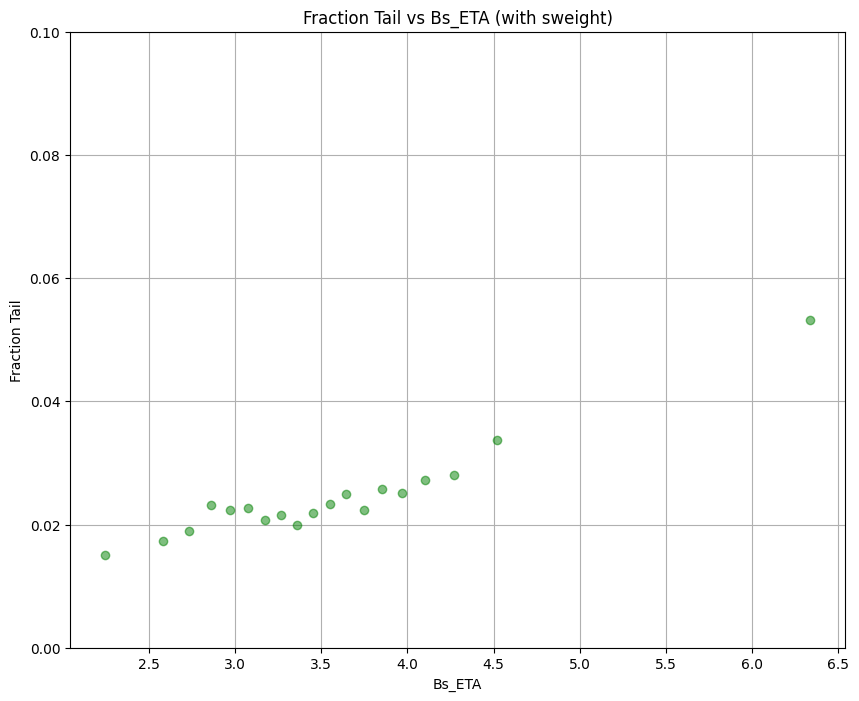

In [66]:

plt.figure(figsize=(10, 8))
plt.errorbar(N_event_ETA_data['mid_bin_point'],N_event_prompt,alpha=0.5, fmt='o', color='green')
plt.title("Fraction Tail vs Bs_ETA (with sweight)")
plt.xlabel('Bs_ETA')
plt.ylabel("Fraction Tail")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
#plt.legend()
plt.grid(True)
plt.show()

### Tail plot ETA

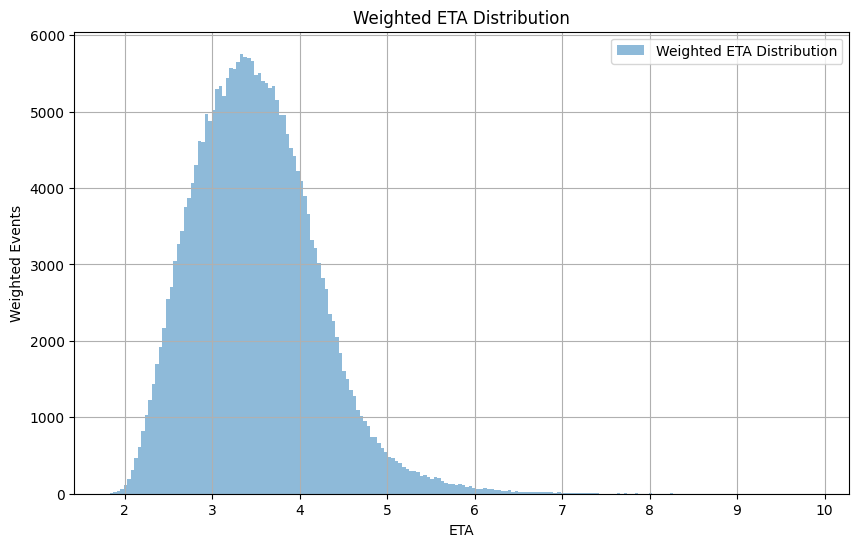

In [67]:
# ETA
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['Bs_ETA'], bins=200,  alpha=0.5, label='Weighted ETA Distribution')
plt.title('Weighted ETA Distribution')
plt.xlabel('ETA')
plt.ylabel('Weighted Events')
plt.legend()
plt.grid(True)
plt.show()

### Sigma vs PV_Z 

In [68]:
cut_df_c

,Bs_DTF_PV_CTAU,Bs_DTF_PV_CTAUERR,RUNNUMBER,NPVs,Jpsi_M,Bs_ETA,Bs_PT,Bs_BPVZ,Bs_BPVIPCHI2,Bs_PZ,Bs_TRUE_LIFETIME,Bs_DTF_PV_TAUERR (ps),Bs_DTF_PV_TAU (ps),Cot_theta,T_Diff (ps),shifted_T_Diff (ps)
3,1.091343,0.012058,22659218,6,3079.161621,4.873708,496.245514,37.144798,3.105215,32455.189453,0.003715,0.040192,3.637810,65.401474,-0.077209,-0.076053
4,0.258914,0.008388,22659218,4,3095.403564,2.746099,11590.852539,44.561298,0.971056,89935.273438,0.000901,0.027959,0.863048,7.759160,-0.038028,-0.036872
7,0.561554,0.008727,22659218,8,3102.504639,3.287241,4181.135742,-77.849602,0.947357,55888.128906,0.001884,0.029088,1.871847,13.366734,-0.011842,-0.010686
8,0.178866,0.010436,22659218,4,3087.402588,2.988320,5480.886719,-38.676399,4.233104,54268.640625,0.000607,0.034787,0.596219,9.901435,-0.010904,-0.009747
14,1.004290,0.008375,22659218,1,3097.784912,3.204259,6885.703613,-43.768501,2.434763,84683.906250,0.003363,0.027916,3.347635,12.298512,-0.014989,-0.013833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534278,2.238258,0.013677,22715396,6,3110.307861,3.496879,3600.500244,-38.309399,4.989733,59379.011719,0.007463,0.045591,7.460859,16.491879,-0.002291,-0.001135
534279,0.629731,0.009540,22715396,8,3095.959961,3.856741,5683.726074,100.733200,4.168538,134391.515625,0.002113,0.031802,2.099102,23.644966,-0.014312,-0.013155
534284,0.825043,0.010852,22715396,4,3096.178223,5.573972,949.529419,42.446899,2.842815,125095.562500,0.002795,0.036173,2.750143,131.744797,-0.045248,-0.044092
534286,0.192358,0.006784,22715396,4,3102.965576,3.400936,7171.347656,-12.336500,3.604300,107432.390625,0.000667,0.022613,0.641195,14.980782,-0.026169,-0.025013


# Strange Peak

In [72]:
num = np.linspace(0,1,20)
ini_cut_ETA = cut_df_c[(cut_df_c['Bs_ETA'] > 2) & (cut_df_c['Bs_ETA'] < 8)]
quantiles_ETA_BPVZ = np.quantile(ini_cut_ETA['Bs_ETA'], num)
data_ETA_BPVZ = quantiles_cutting_data ('Bs_ETA', 'shifted_T_Diff (ps)', 
                                         ini_cut_ETA,quantiles_ETA_BPVZ,[2,8],[-10,10],nbin=500)

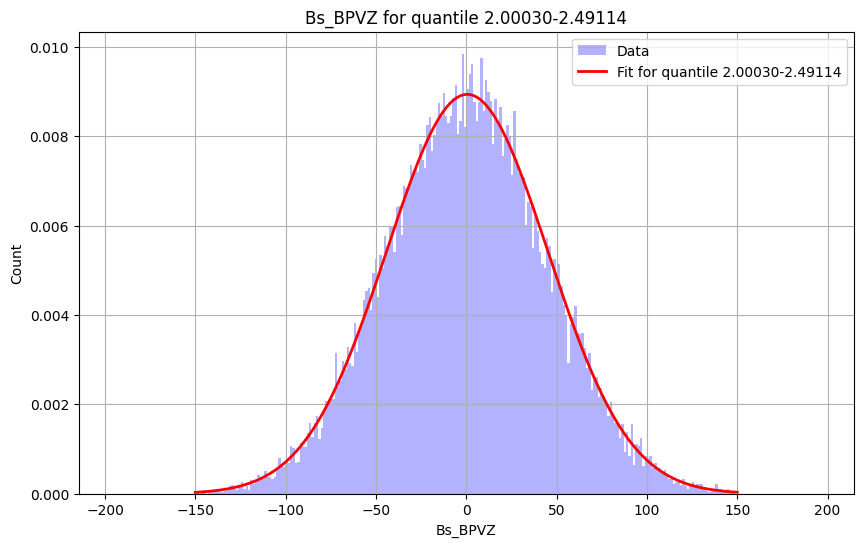

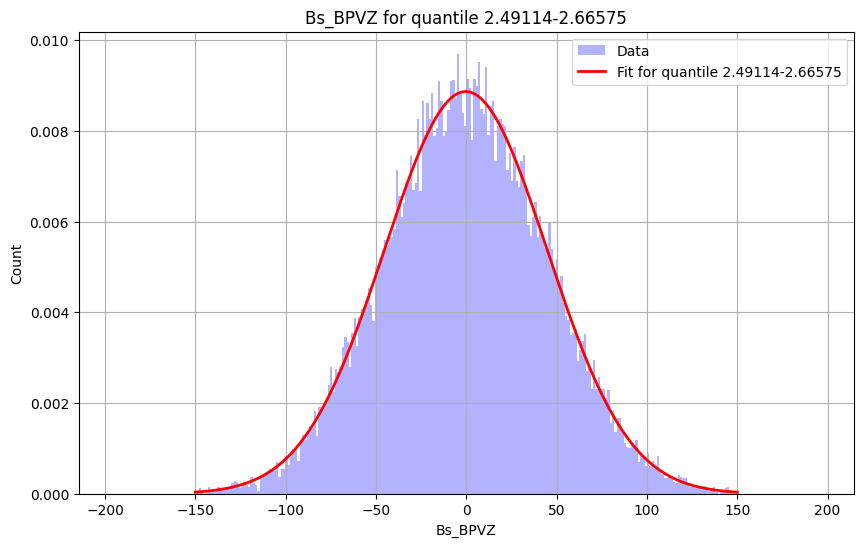

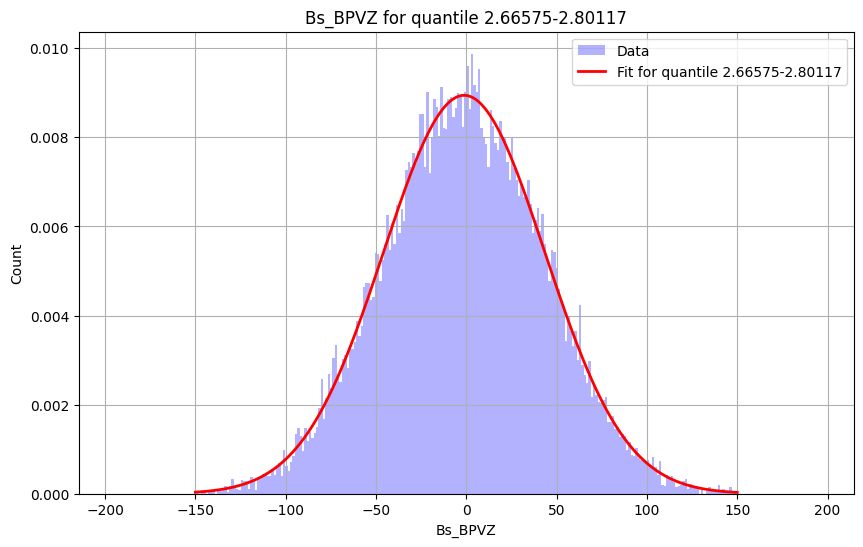

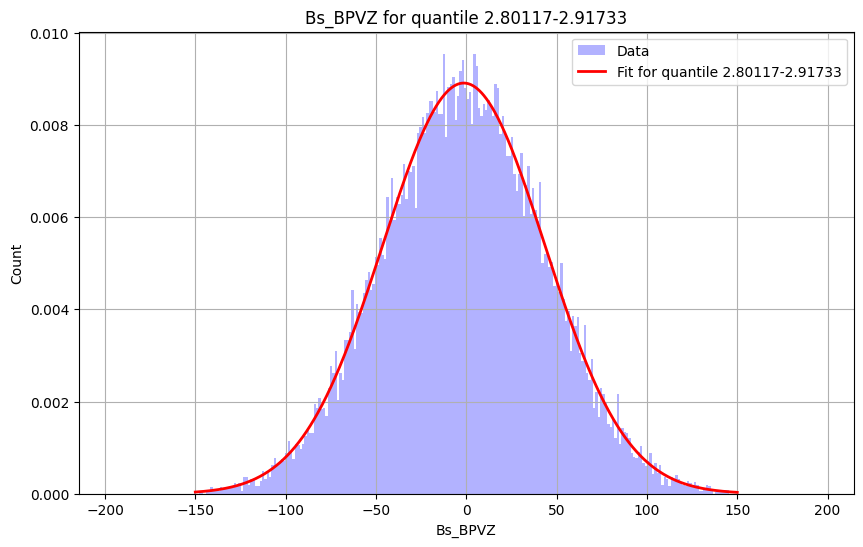

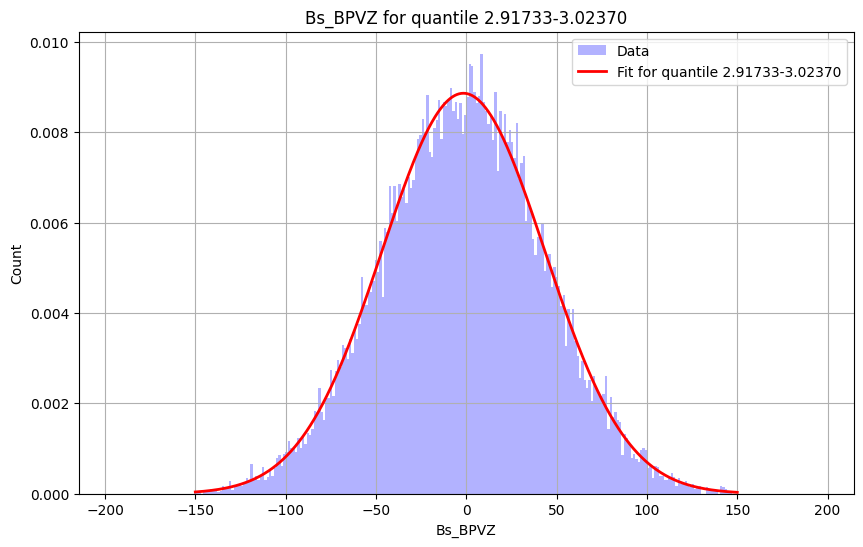

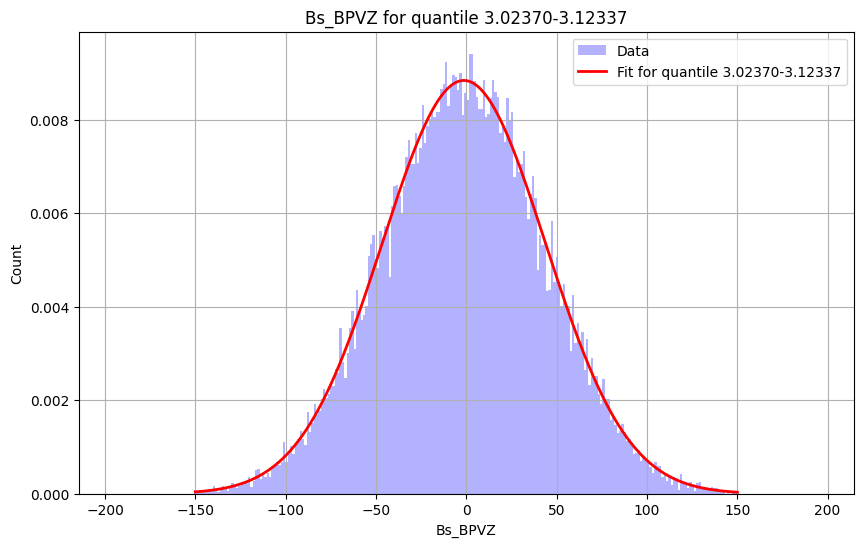

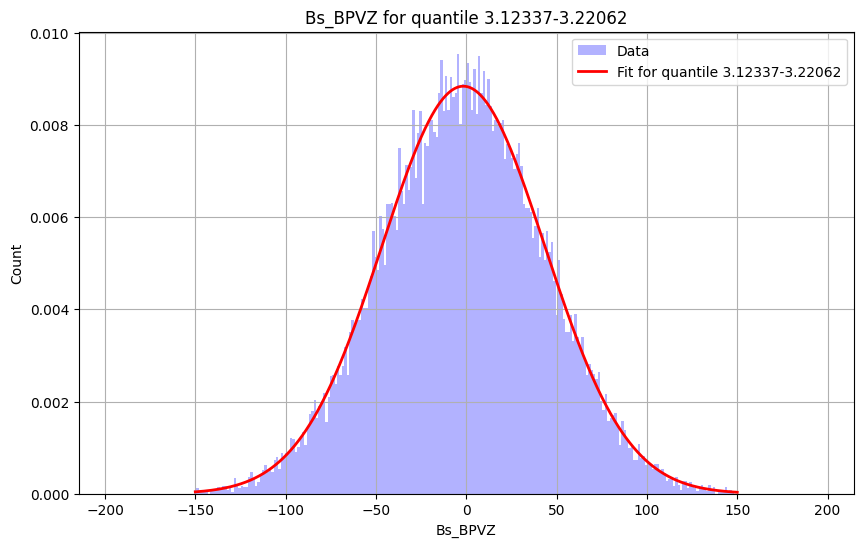

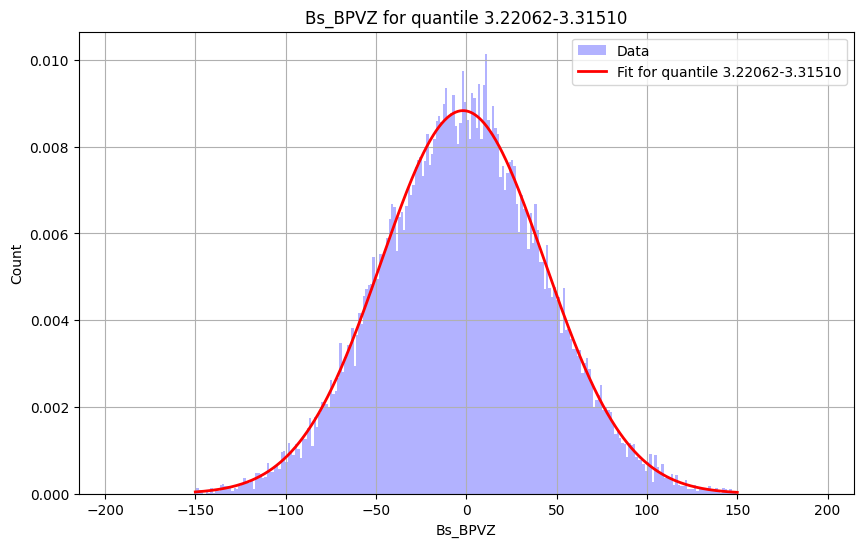

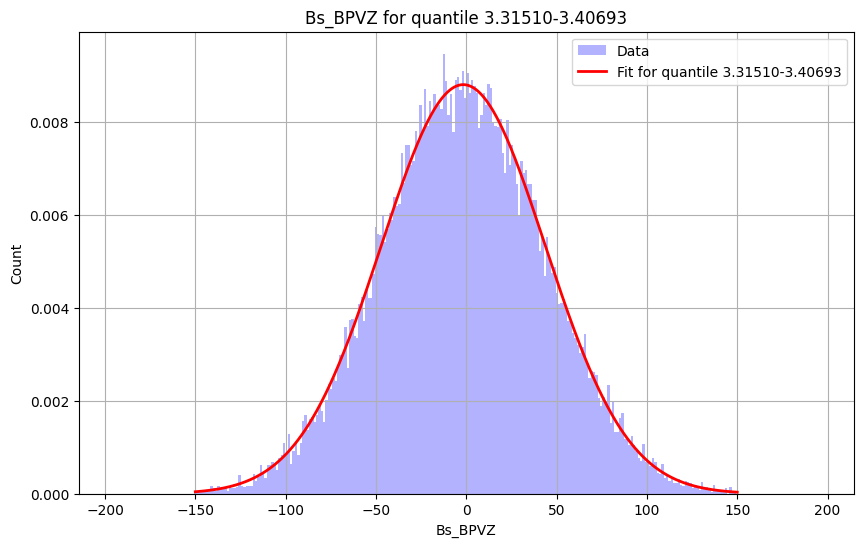

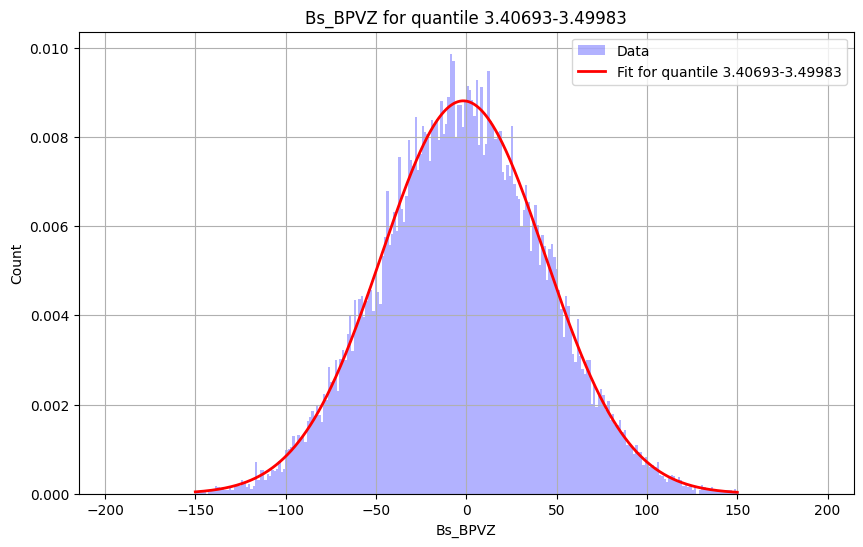

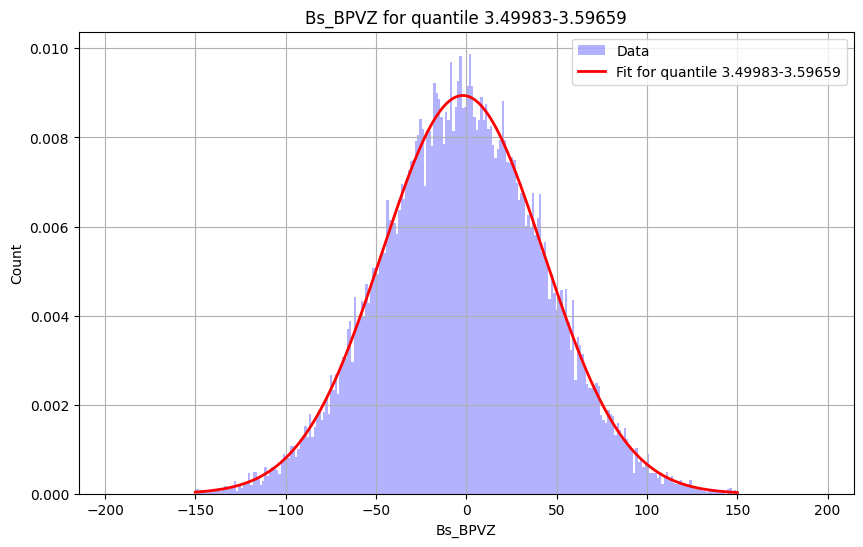

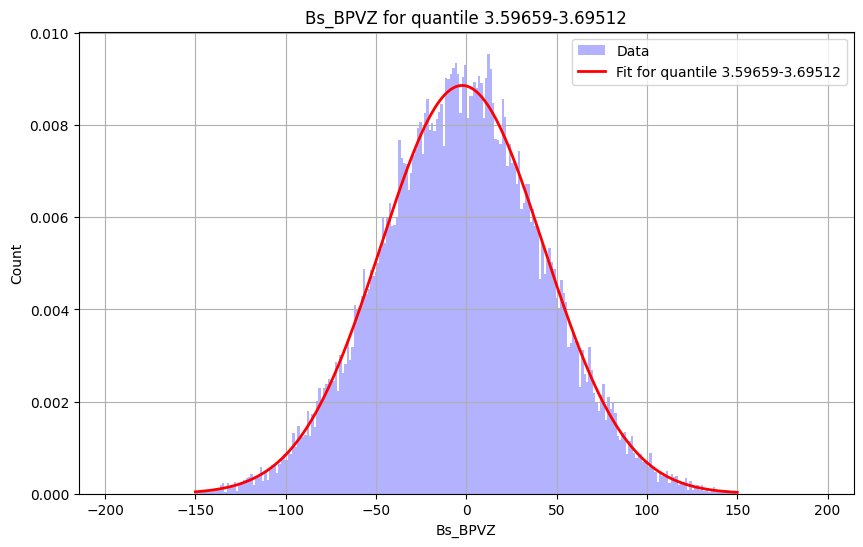

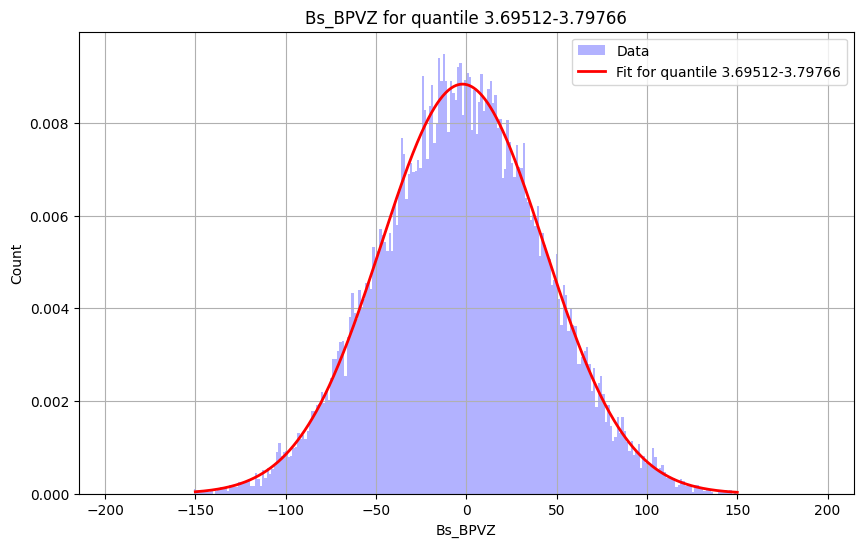

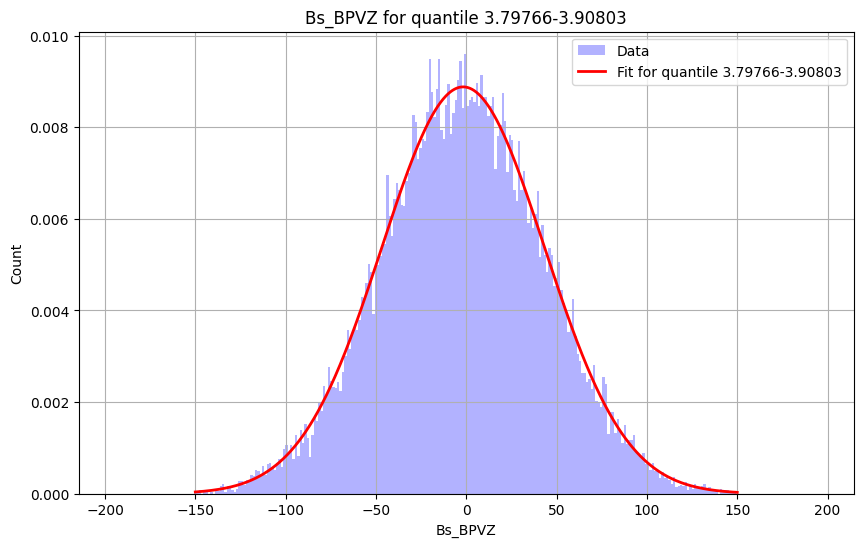

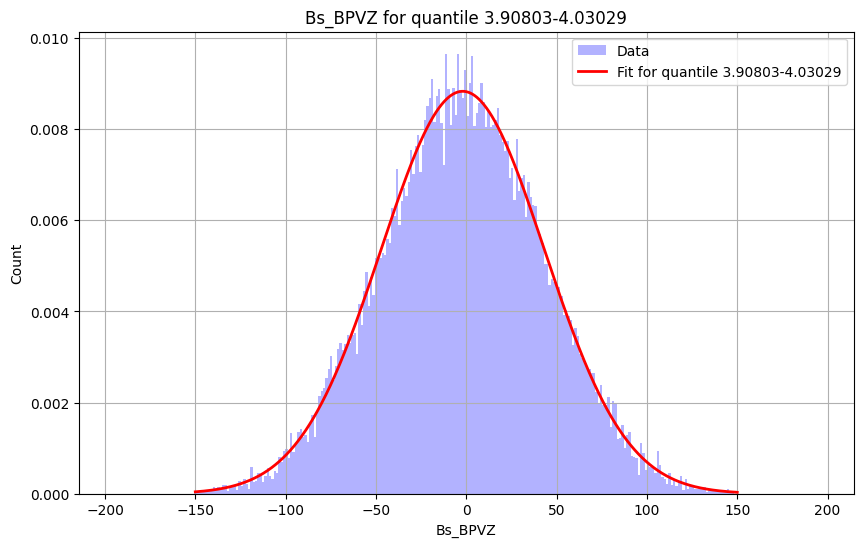

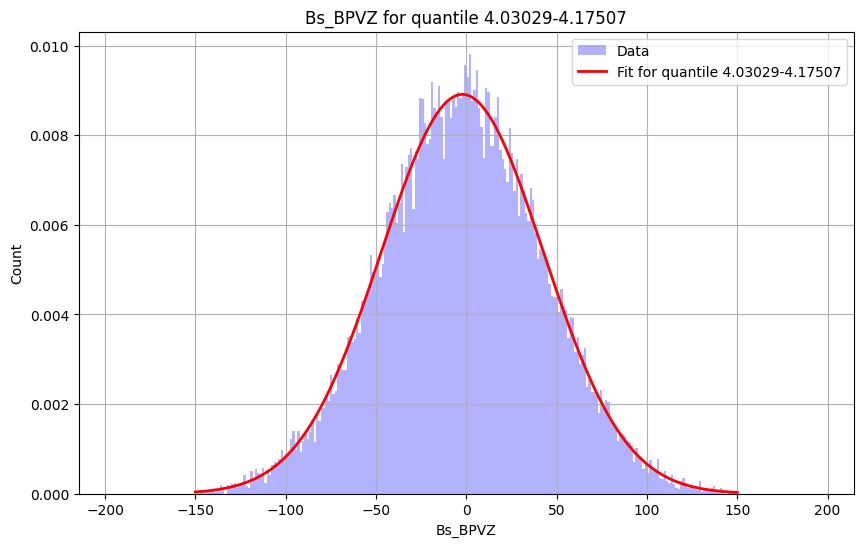

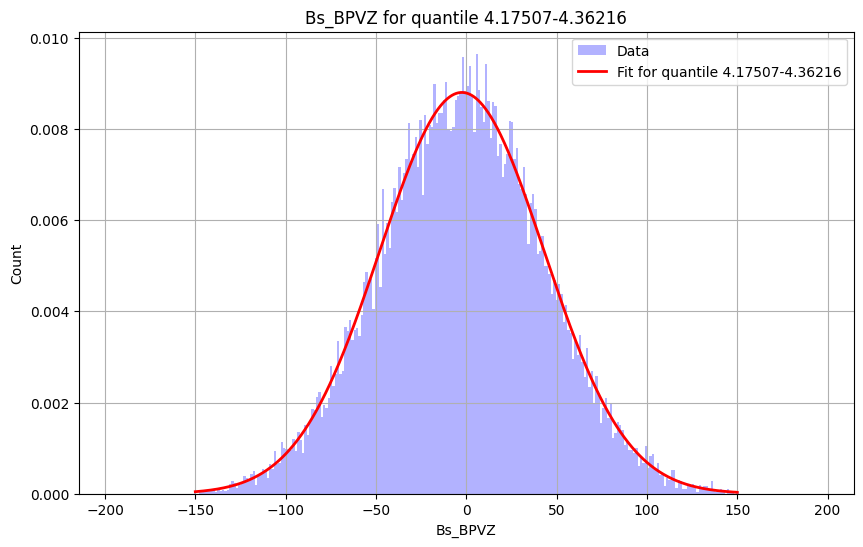

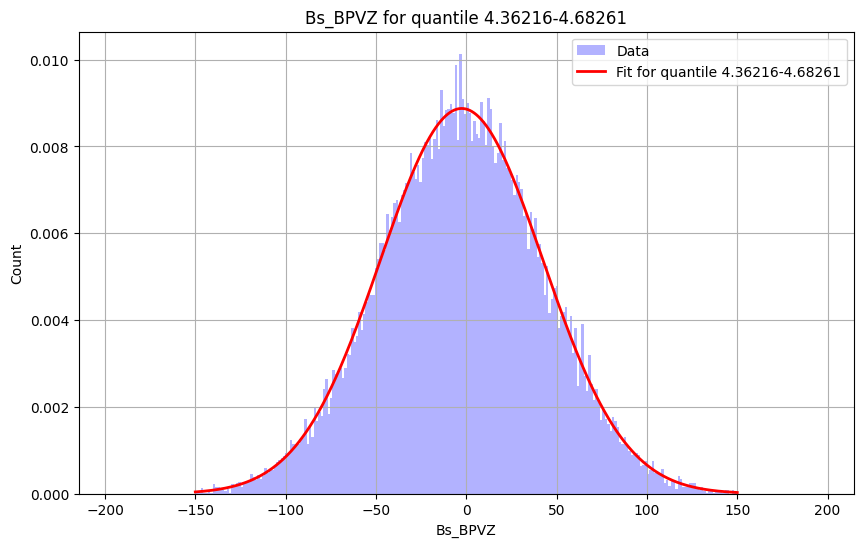

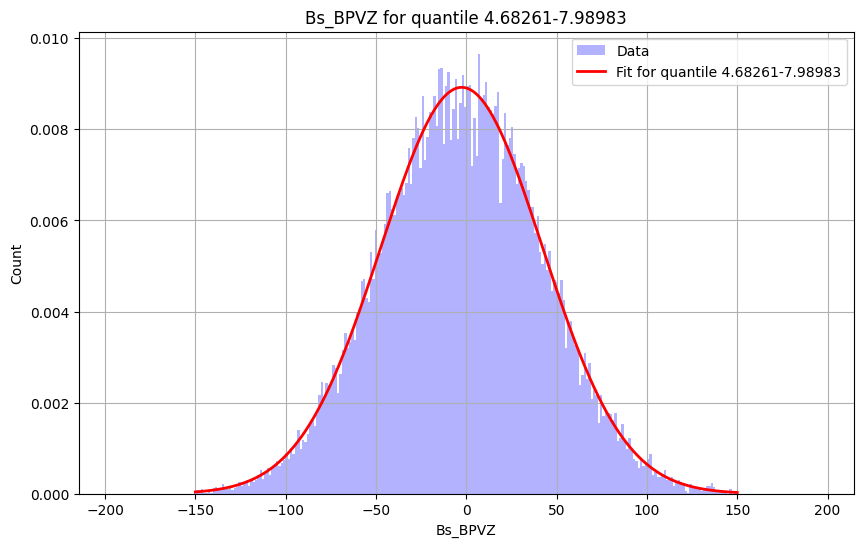

<Figure size 1000x600 with 0 Axes>

In [74]:
num= np.linspace(0,1,20)

ini_cut = cut_df_c[(cut_df_c['Bs_ETA'] > 2) & (cut_df_c['Bs_ETA'] < 8)]
quantiles_mcdata = np.quantile(ini_cut ['Bs_ETA'], num)

fitting_result_prompt_ETA_BPVZ  = quantiles_cutting_cal('Bs_ETA','Bs_BPVZ',quantiles_mcdata, 
                                       combined_df_mcdata,cut_on_condata=[0.003, 0.07],cut_on_quantity = [-150,150]
                                         ,fitting_plots=True)


# selected_condition_quantity, filtered_quantity,combined_df, quantilesfitting_results,xyplot=False, x_unit=None, y_unit=None)

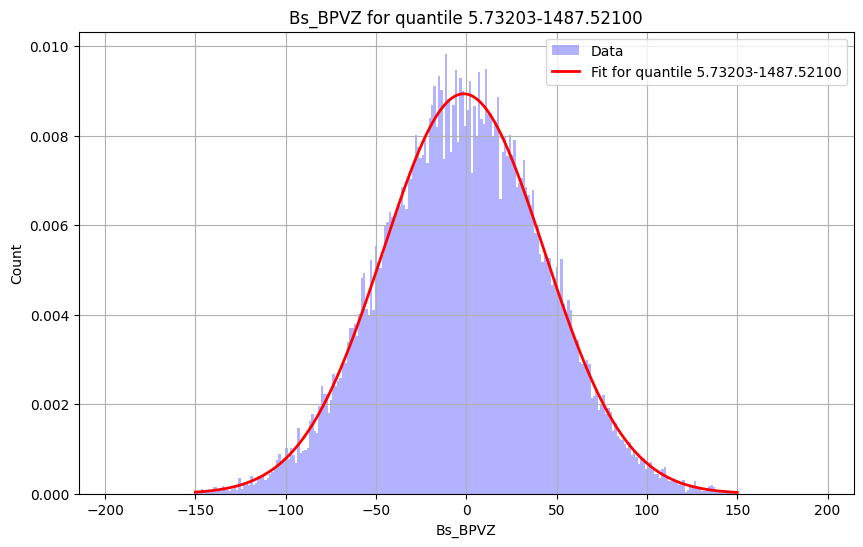

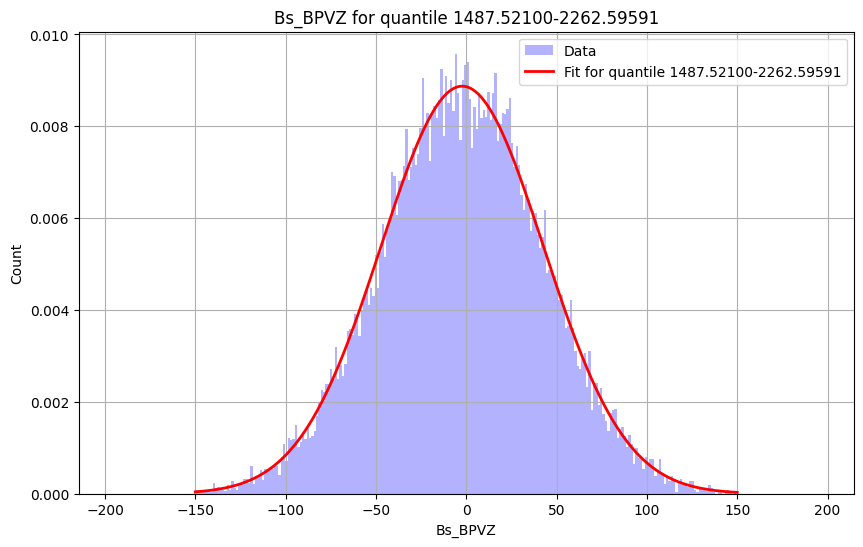

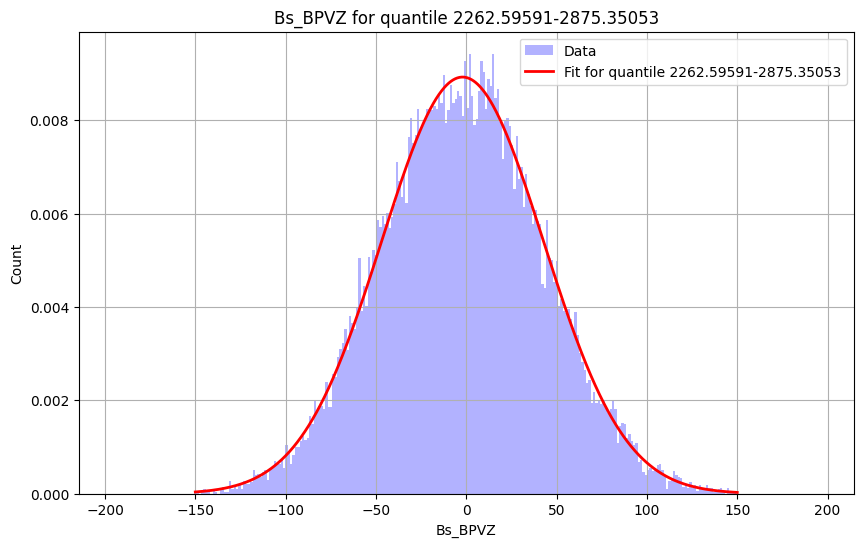

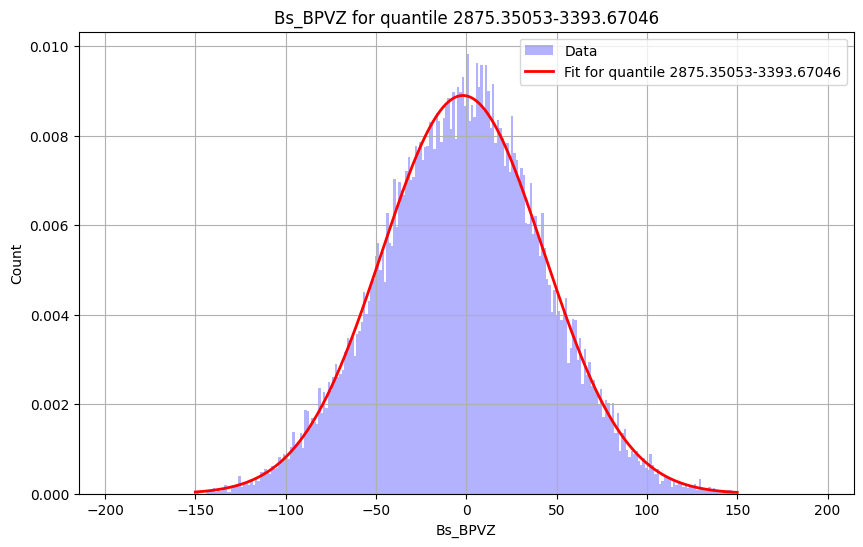

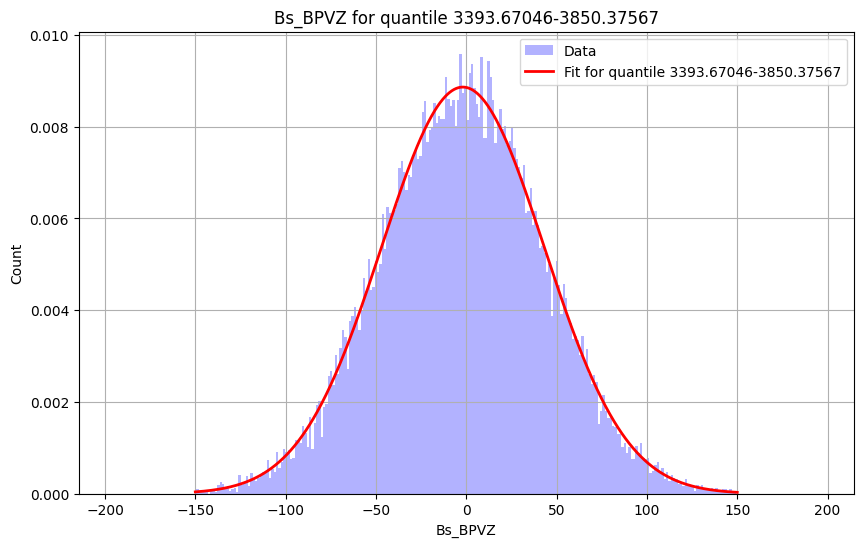

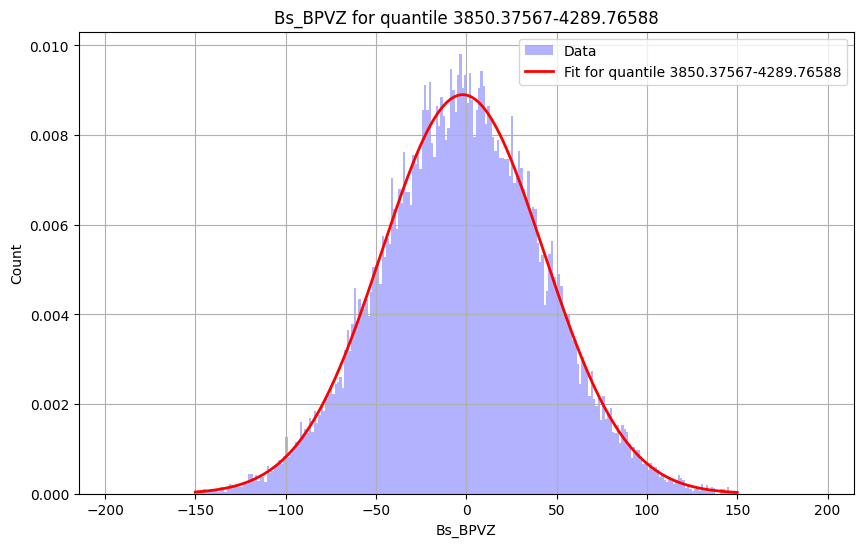

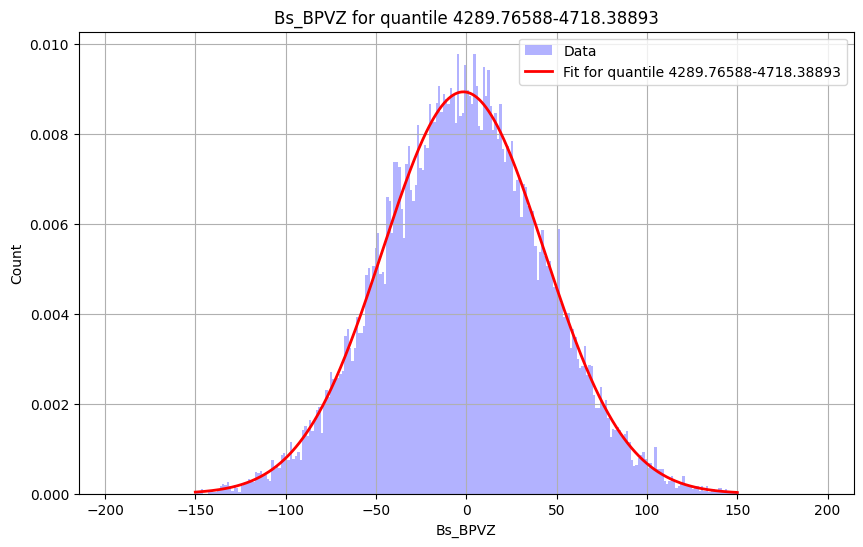

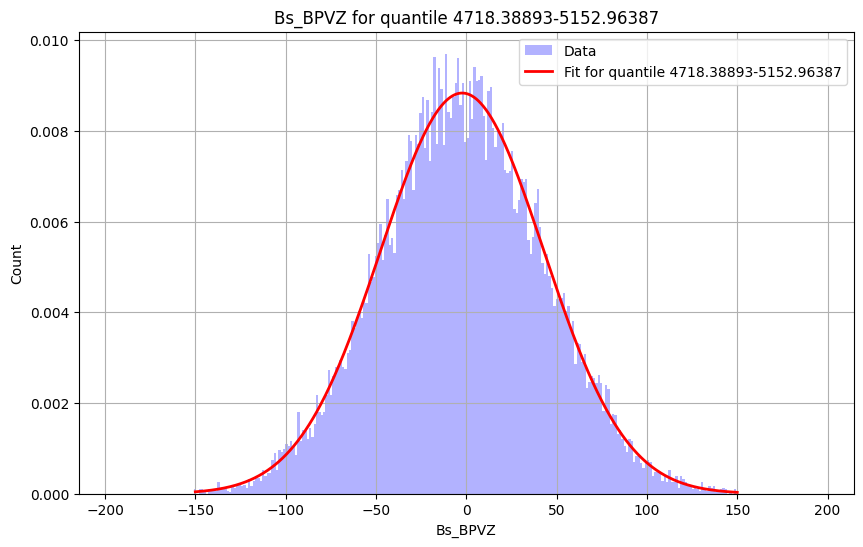

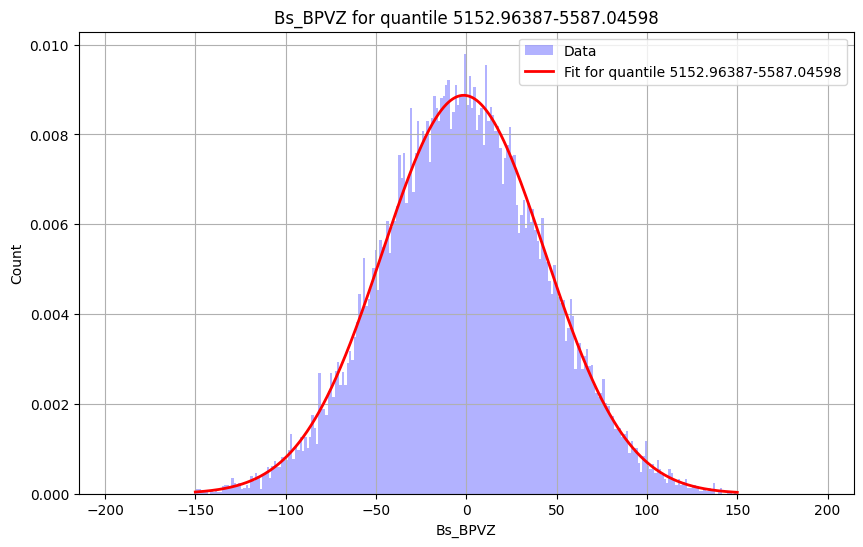

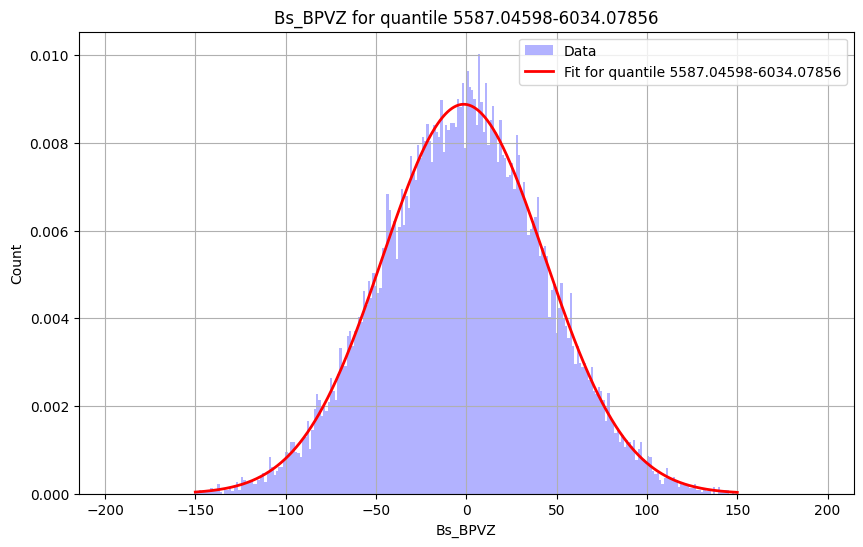

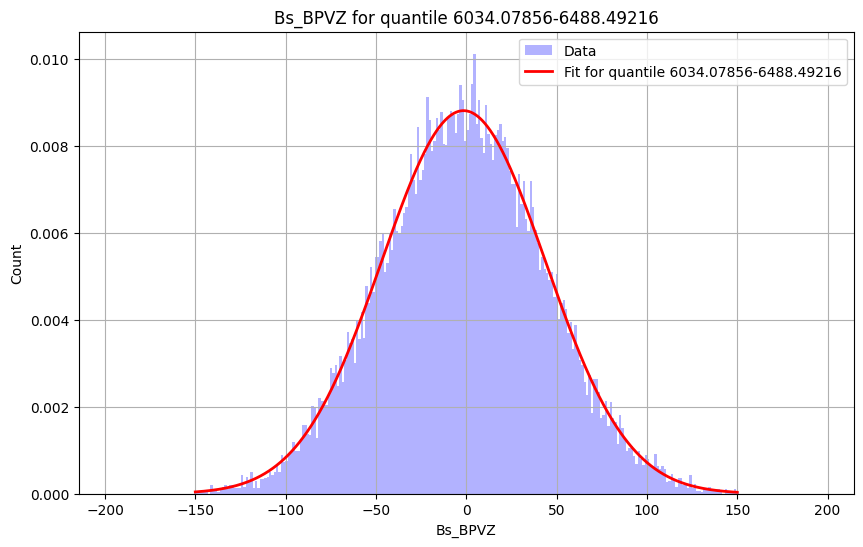

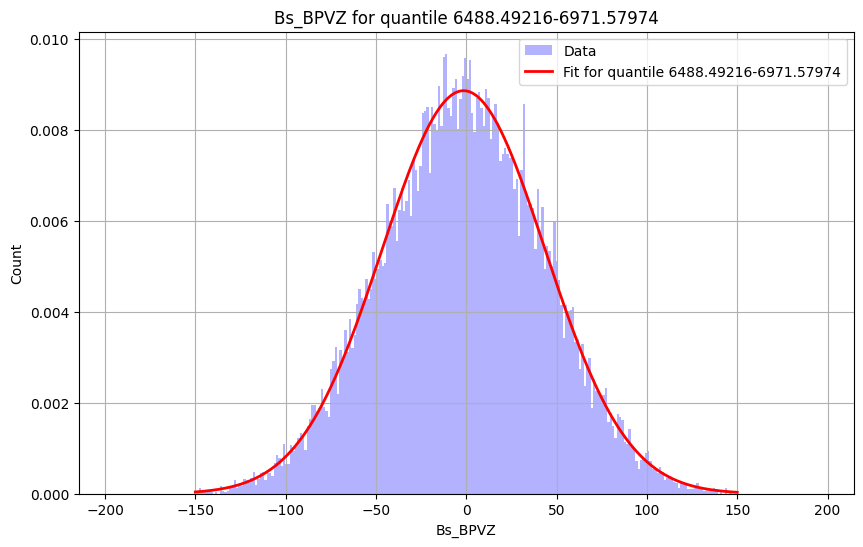

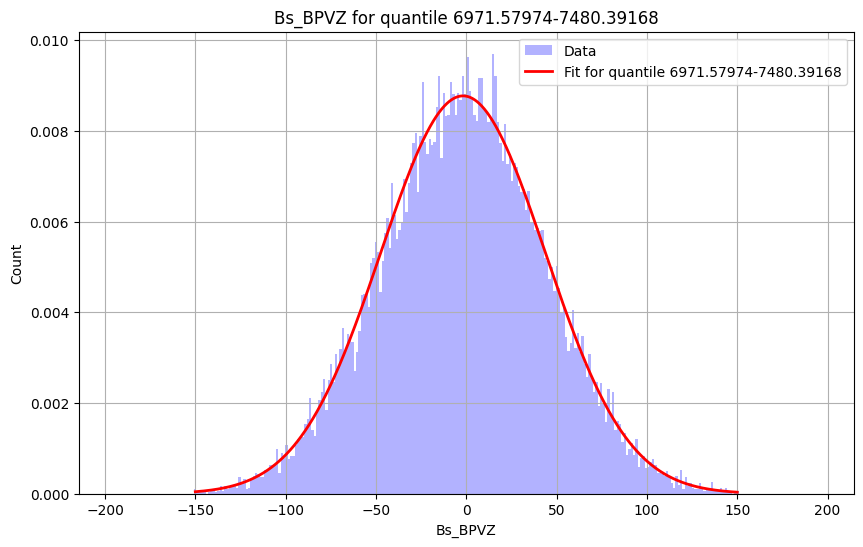

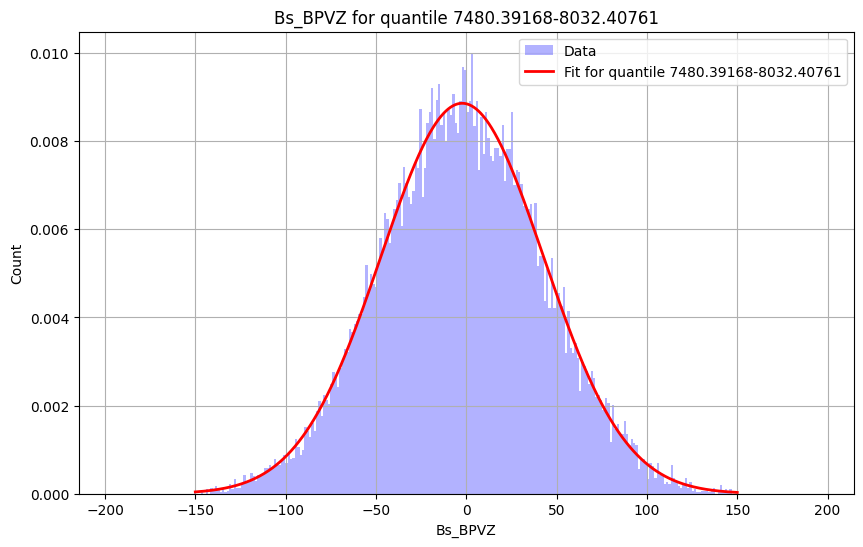

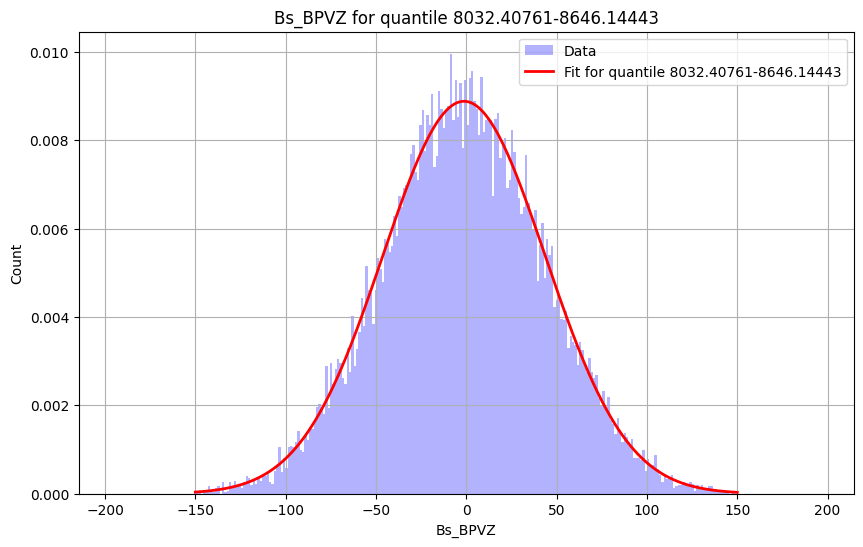

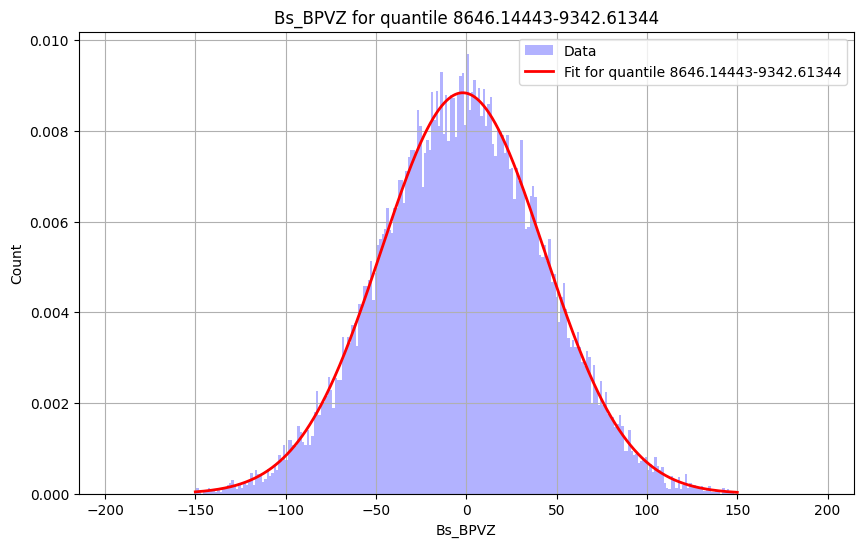

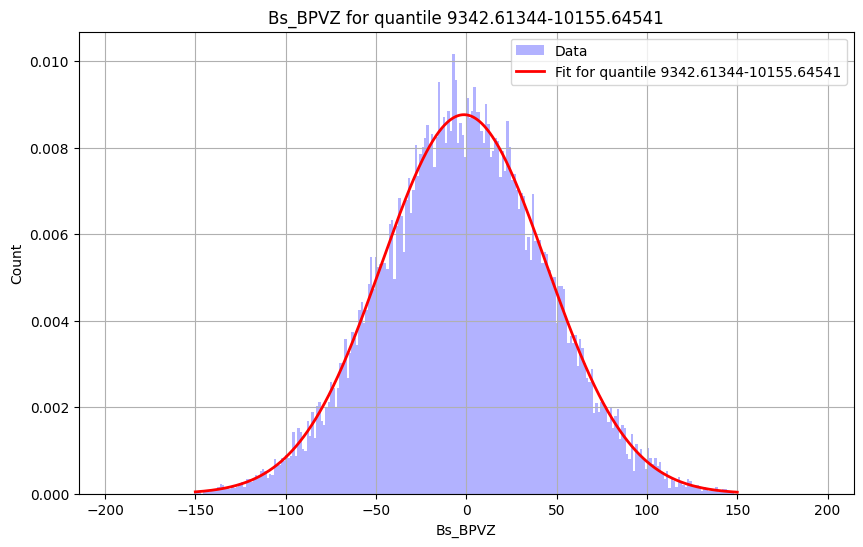

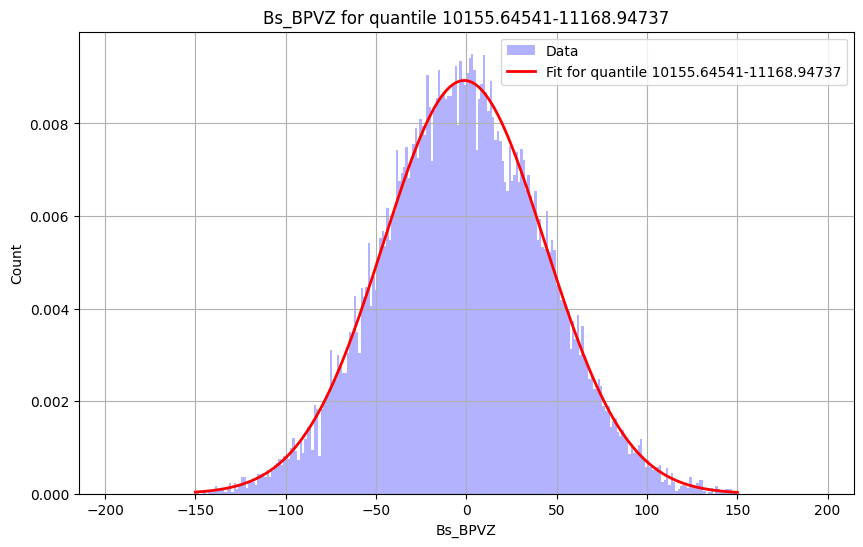

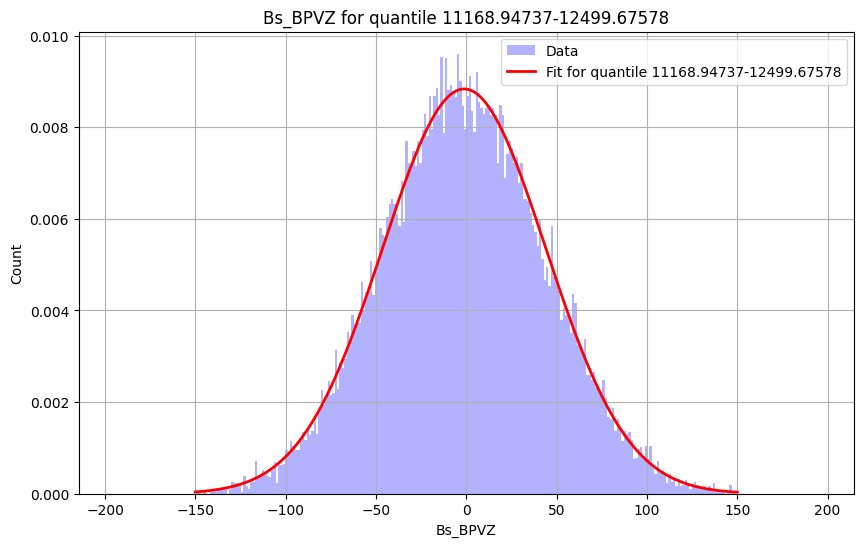

<Figure size 1000x600 with 0 Axes>

In [76]:
num= np.linspace(0,1,20)

ini_cut = cut_df_c[(cut_df_c['Bs_PT'] > 0) & (cut_df_c['Bs_PT'] < 12500)]
quantiles_mcdata = np.quantile(ini_cut ['Bs_PT'], num)

fitting_result_mcdata_PT_BPVZ  = quantiles_cutting_cal('Bs_PT','Bs_BPVZ',quantiles_mcdata, 
                                       combined_df_mcdata,cut_on_condata=[0.003, 0.07],cut_on_quantity = [-150,150]
                                         ,fitting_plots=True)


# selected_condition_quantity, filtered_quantity,combined_df, quantilesfitting_results,xyplot=False, x_unit=None, y_unit=None)

# Sigma vs Bs_BPVZ

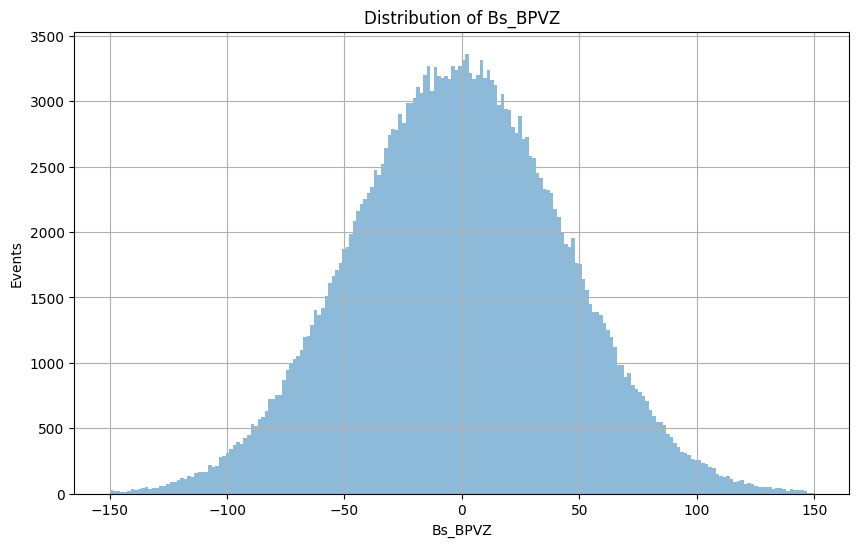

In [77]:
# PT
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['Bs_BPVZ'], bins=200, range=(-150,150), alpha=0.5)
plt.title("Distribution of Bs_BPVZ")
plt.xlabel('Bs_BPVZ')
plt.ylabel('Events')
plt.grid(True)
plt.show()

In [79]:
num = np.linspace(0,1,20)
# BPVZ
ini_cut_BPVZ = cut_df_c[(cut_df_c['Bs_BPVZ'] > -150) & (cut_df_c['Bs_BPVZ'] < 150)]
quantiles_BPVZ_mcdata_sig = np.quantile(ini_cut_BPVZ['Bs_BPVZ'], num)
eff_cutting_BPVZ = quantiles_cutting_data ('Bs_BPVZ', 'shifted_T_Diff (ps)', 
                                         ini_cut_BPVZ,quantiles_BPVZ_mcdata_sig,[-150,150],[-10,10],nbin=500)
sig_eff_BPVZ_sw = array_sig_eff(eff_cutting_BPVZ,'cut_data',d_m_B_ps)

ini_cut_BPVZ = cut_df_c[(cut_df_c['Bs_BPVZ'] > -150) & (cut_df_c['Bs_BPVZ'] < 150)]
quantiles_BPVZ_mcdata = np.quantile(ini_cut_BPVZ['Bs_BPVZ'], num)
rec_cutting_BPVZ = quantiles_cutting_data ('Bs_BPVZ', 'shifted_T_Diff (ps)',
                                         ini_cut_BPVZ,quantiles_BPVZ_mcdata,[2,8],[-100,100],nbin=500)
rec_sig_BPVZ_sw =rec_sigma(rec_cutting_BPVZ['cut_data'],d_m_B_ps)

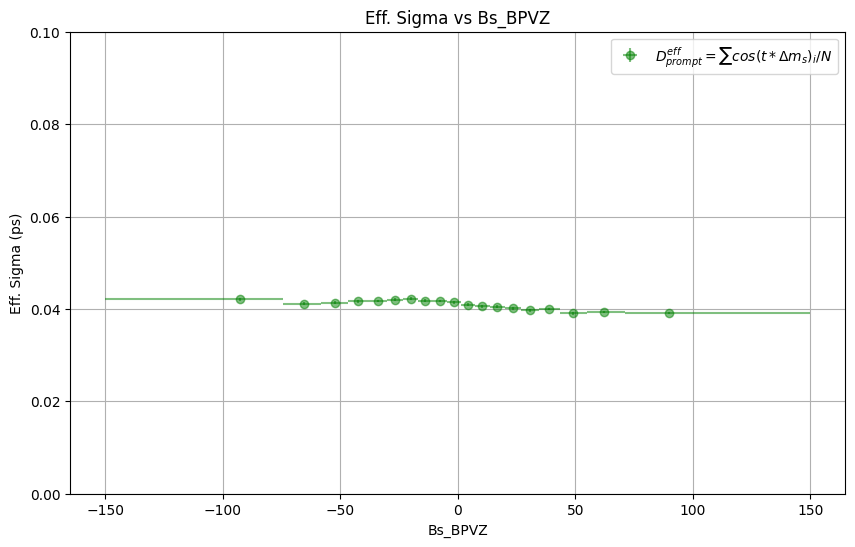

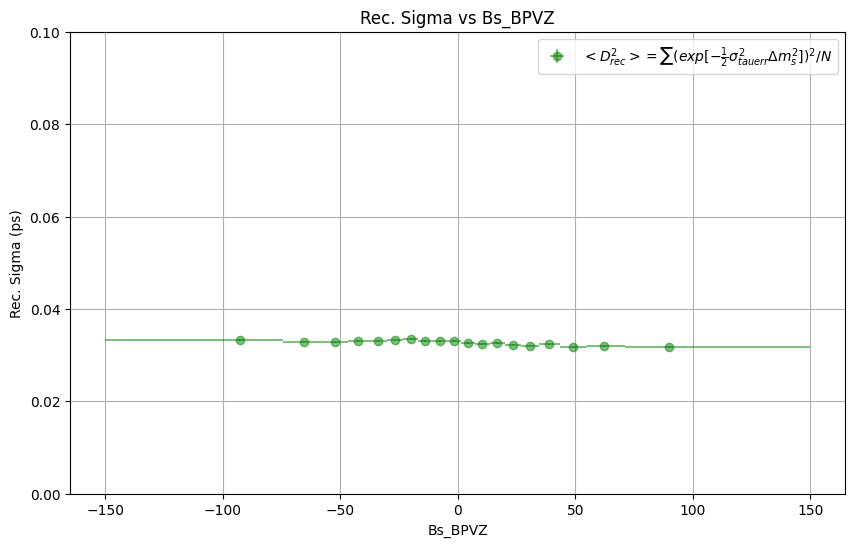

In [80]:
neg_xerr_eff_BPVZ = np.array(eff_cutting_BPVZ['width_bar']) - \
                  (np.array(eff_cutting_BPVZ["mid_bin_point"]) - np.array(eff_cutting_BPVZ["average_point"])) 

pos_xerr_eff_BPVZ = np.array(eff_cutting_BPVZ['width_bar']) + \
                  (np.array(eff_cutting_BPVZ["mid_bin_point"]) - np.array(eff_cutting_BPVZ["average_point"])) 

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(eff_cutting_BPVZ["average_point"],sig_eff_BPVZ_sw['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_BPVZ,pos_xerr_eff_BPVZ],yerr=sig_eff_BPVZ_sw['sigma(sigma_eff)'], 
             label =  r"$D_{prompt}^{eff} = \sum cos(t * \Delta m_s)_i / N$")


# Customize the plot
plt.title("Eff. Sigma vs Bs_BPVZ")
plt.xlabel('Bs_BPVZ')
plt.ylabel("Eff. Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

neg_xerr_rec_BPVZ = np.array(rec_cutting_BPVZ['width_bar']) - \
                  (np.array(rec_cutting_BPVZ["mid_bin_point"]) - np.array(rec_cutting_BPVZ["average_point"])) 

pos_xerr_rec_BPVZ = np.array(rec_cutting_BPVZ['width_bar']) + \
                  (np.array(rec_cutting_BPVZ["mid_bin_point"]) - np.array(rec_cutting_BPVZ["average_point"])) 

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(rec_cutting_BPVZ["average_point"],rec_sig_BPVZ_sw['sigma_rec'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_rec_BPVZ,pos_xerr_rec_BPVZ],yerr=rec_sig_BPVZ_sw['sigma(sigma_rec)'], 
             label = r"$< D_{rec} ^2> = \sum (exp[-\frac{1}{2}\sigma_{T_{diff}}^2\Delta m_s^2])^2 / N $")


# Customize the plot
plt.title("Rec. Sigma vs Bs_BPVZ")
plt.xlabel('Bs_BPVZ')
plt.ylabel("Rec. Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

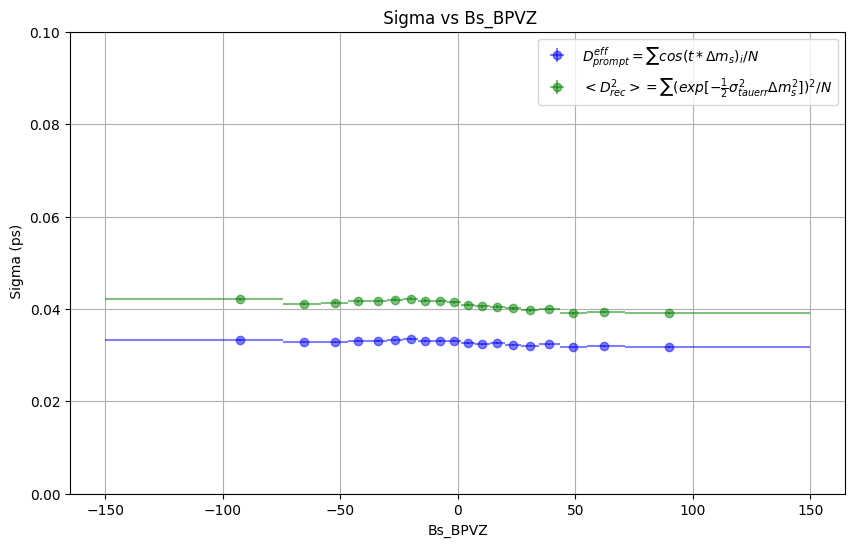

In [81]:
plt.figure(figsize=(10, 6))
plt.errorbar(rec_cutting_BPVZ["average_point"],rec_sig_BPVZ_sw['sigma_rec'] ,alpha=0.5, fmt='o', color='blue',
             xerr=[neg_xerr_rec_BPVZ,pos_xerr_rec_BPVZ],yerr=rec_sig_BPVZ_sw['sigma(sigma_rec)'], 
             label =  r"$D_{prompt}^{eff} = \sum cos(t * \Delta m_s)_i / N$")

plt.errorbar(eff_cutting_BPVZ["average_point"],sig_eff_BPVZ_sw['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_BPVZ,pos_xerr_eff_BPVZ],yerr=sig_eff_BPVZ_sw['sigma(sigma_eff)'], 
             label = r"$< D_{rec} ^2> = \sum (exp[-\frac{1}{2}\sigma_{T_{diff}}^2\Delta m_s^2])^2 / N $")


# Customize the plot
plt.title(" Sigma vs Bs_BPVZ")
plt.xlabel('Bs_BPVZ')
plt.ylabel(" Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
plt.legend()
# Show the plot
plt.show()

### Bs_BPVIPCHI2

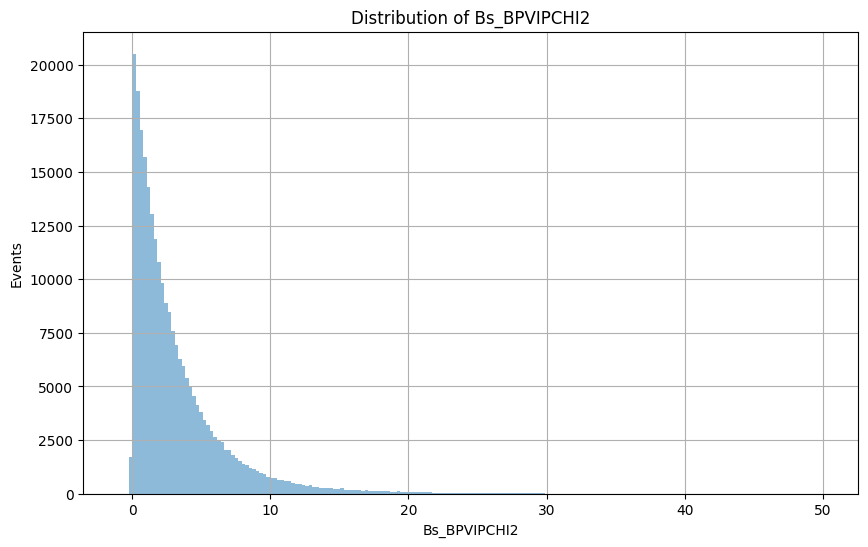

In [82]:
# PT
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['Bs_BPVIPCHI2'], bins=200, range=(-1,50), alpha=0.5)
plt.title("Distribution of Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel('Events')
plt.grid(True)
plt.show()

In [84]:
num = np.linspace(0,1,20)
# ETA
ini_cut_IPCHI2 = cut_df_c[(cut_df_c['Bs_BPVIPCHI2'] > -150) & (cut_df_c['Bs_BPVIPCHI2'] < 150)]
quantiles_IPCHI2_mcdata_sig = np.quantile(ini_cut_IPCHI2['Bs_BPVIPCHI2'], num)
eff_cutting_IPCHI2 = quantiles_cutting_data ('Bs_BPVIPCHI2', 'shifted_T_Diff (ps)', 
                                         ini_cut_IPCHI2,quantiles_IPCHI2_mcdata_sig,[-150,150],[-10,10],nbin=500)
sig_eff_IPCHI2 = array_sig_eff(eff_cutting_IPCHI2,'cut_data',d_m_B_ps)

ini_cut_IPCHI2 = cut_df_c[(cut_df_c['Bs_BPVIPCHI2'] > -150) & (cut_df_c['Bs_BPVIPCHI2'] < 150)]
quantiles_IPCHI2_mcdata = np.quantile(ini_cut_IPCHI2['Bs_BPVIPCHI2'], num)
rec_cutting_IPCHI2 = quantiles_cutting_data ('Bs_BPVIPCHI2', 'shifted_T_Diff (ps)',
                                         ini_cut_IPCHI2,quantiles_IPCHI2_mcdata,[2,8],[-100,100],nbin=500)
rec_sig_IPCHI2 =rec_sigma(rec_cutting_IPCHI2['cut_data'],d_m_B_ps)

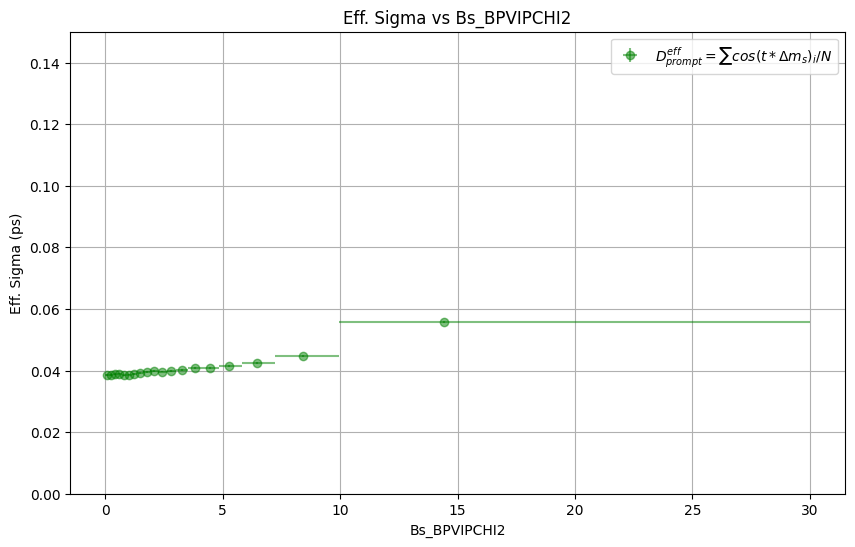

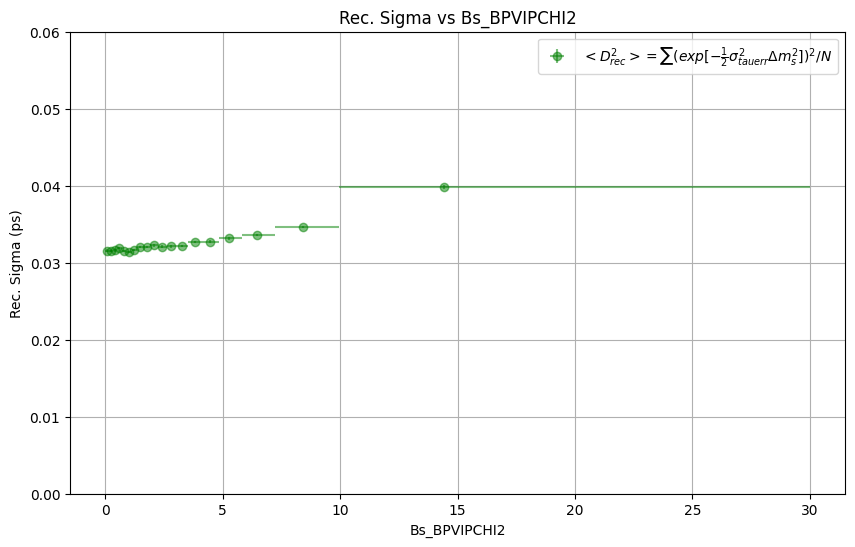

In [85]:
neg_xerr_eff_IPCHI2 = np.array(eff_cutting_IPCHI2['width_bar']) - \
                  (np.array(eff_cutting_IPCHI2["mid_bin_point"]) - np.array(eff_cutting_IPCHI2["average_point"])) 

pos_xerr_eff_IPCHI2 = np.array(eff_cutting_IPCHI2['width_bar']) + \
                  (np.array(eff_cutting_IPCHI2["mid_bin_point"]) - np.array(eff_cutting_IPCHI2["average_point"])) 

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(eff_cutting_IPCHI2["average_point"],sig_eff_IPCHI2['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_IPCHI2,pos_xerr_eff_IPCHI2],yerr=sig_eff_IPCHI2['sigma(sigma_eff)'], 
             label =  r"$D_{prompt}^{eff} = \sum cos(t * \Delta m_s)_i / N$")


# Customize the plot
plt.title("Eff. Sigma vs Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel("Eff. Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.15)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

neg_xerr_rec_IPCHI2 = np.array(rec_cutting_IPCHI2['width_bar']) - \
                  (np.array(rec_cutting_IPCHI2["mid_bin_point"]) - np.array(rec_cutting_IPCHI2["average_point"])) 

pos_xerr_rec_IPCHI2 = np.array(rec_cutting_IPCHI2['width_bar']) + \
                  (np.array(rec_cutting_IPCHI2["mid_bin_point"]) - np.array(rec_cutting_IPCHI2["average_point"])) 

# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(rec_cutting_IPCHI2["average_point"],rec_sig_IPCHI2['sigma_rec'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_rec_IPCHI2,pos_xerr_rec_IPCHI2],yerr=rec_sig_IPCHI2['sigma(sigma_rec)'], 
             label = r"$< D_{rec} ^2> = \sum (exp[-\frac{1}{2}\sigma_{T_{diff}}^2\Delta m_s^2])^2 / N $")


# Customize the plot
plt.title("Rec. Sigma vs Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel("Rec. Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.06)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

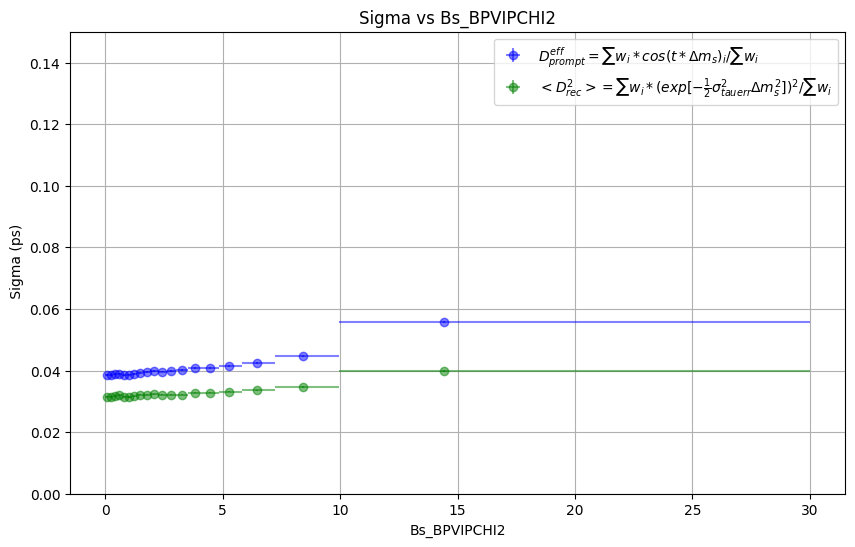

In [88]:
plt.figure(figsize=(10, 6))

plt.errorbar(eff_cutting_IPCHI2["average_point"],sig_eff_IPCHI2['sigma_eff'] ,alpha=0.5, fmt='o', color='blue',
             xerr=[neg_xerr_eff_IPCHI2,pos_xerr_eff_IPCHI2],yerr=sig_eff_IPCHI2['sigma(sigma_eff)'], 
             label = r"$D_{prompt}^{eff} = \sum w_i*cos(t * \Delta m_s)_i / \sum w_i$")

plt.errorbar(rec_cutting_IPCHI2["average_point"],rec_sig_IPCHI2['sigma_rec'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_rec_IPCHI2,pos_xerr_rec_IPCHI2],yerr=rec_sig_IPCHI2['sigma(sigma_rec)'], 
             label = r"$< D_{rec} ^2> = \sum w_i*(exp[-\frac{1}{2}\sigma_{T_{diff} }^2\Delta m_s^2])^2 / \sum w_i$")


# Customize the plot
plt.title("Sigma vs Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel(" Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.15)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

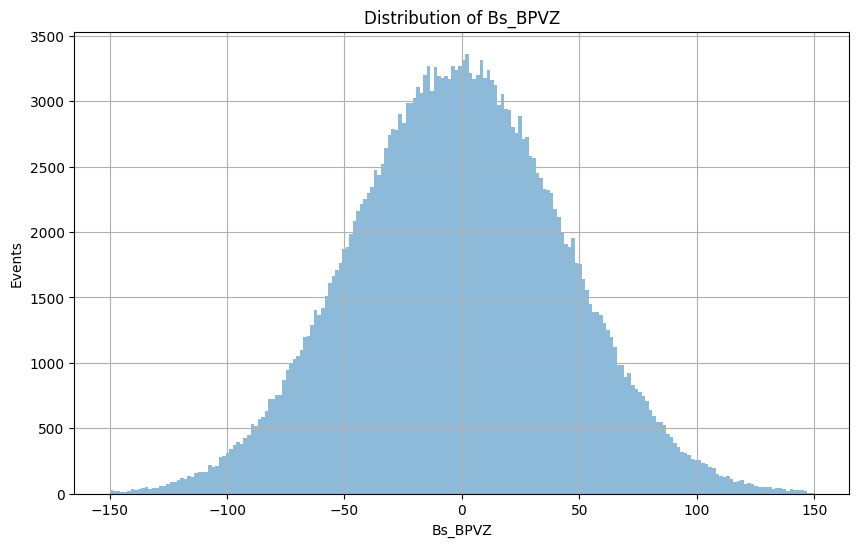

In [90]:
# PT
plt.figure(figsize=(10, 6))
plt.hist(cut_df_c['Bs_BPVZ'], bins=200, range=(-150,150), alpha=0.5)
plt.title("Distribution of Bs_BPVZ")
plt.xlabel('Bs_BPVZ')
plt.ylabel('Events')
plt.grid(True)
plt.show()

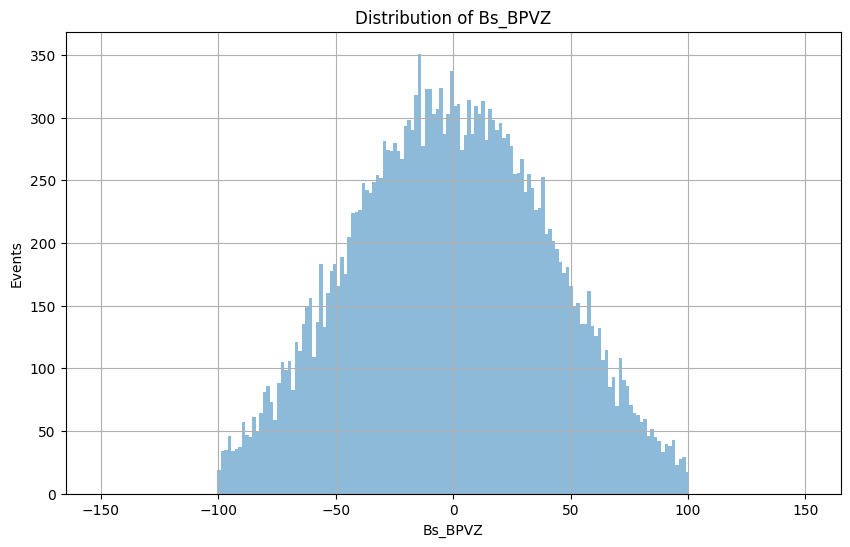

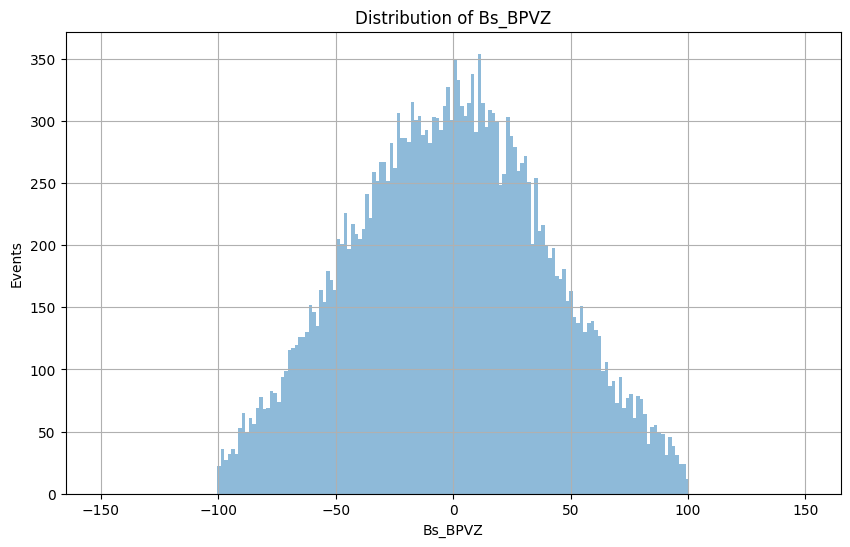

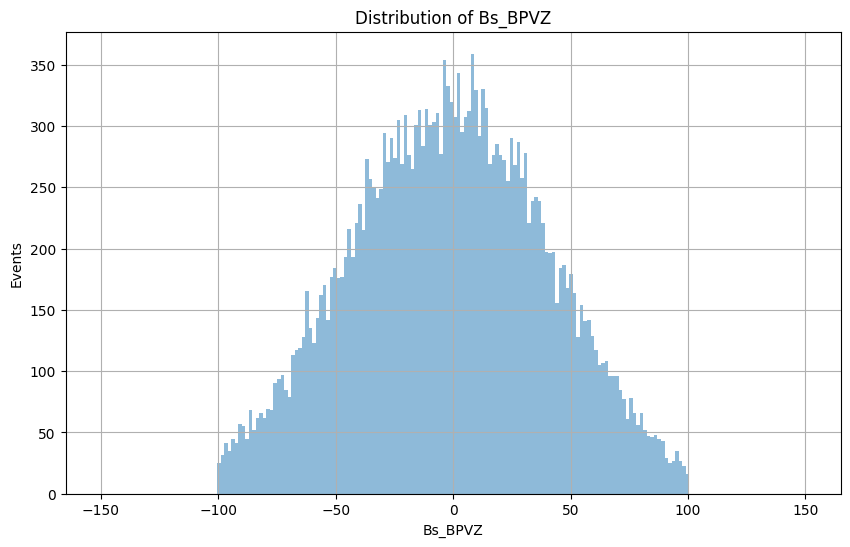

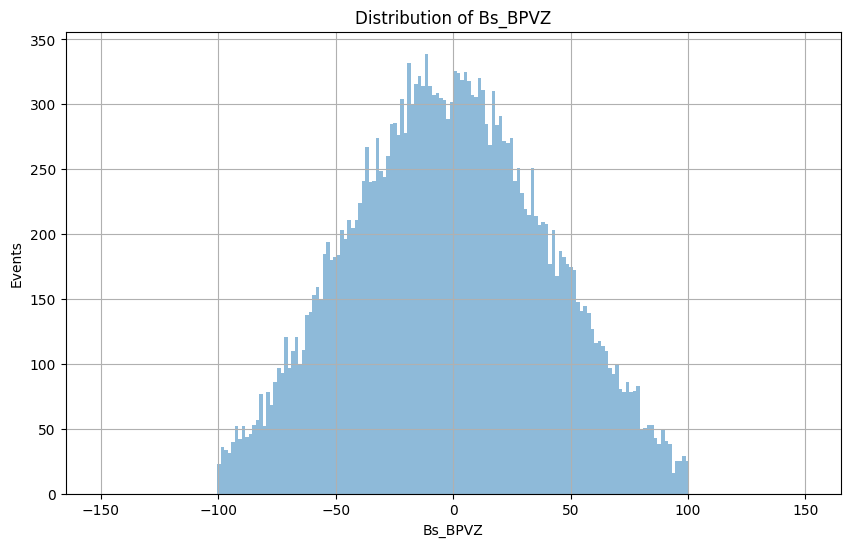

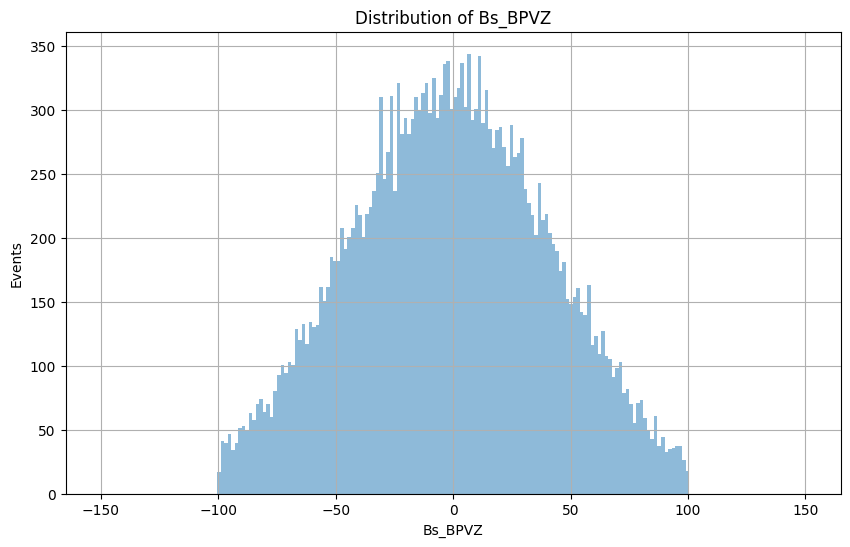

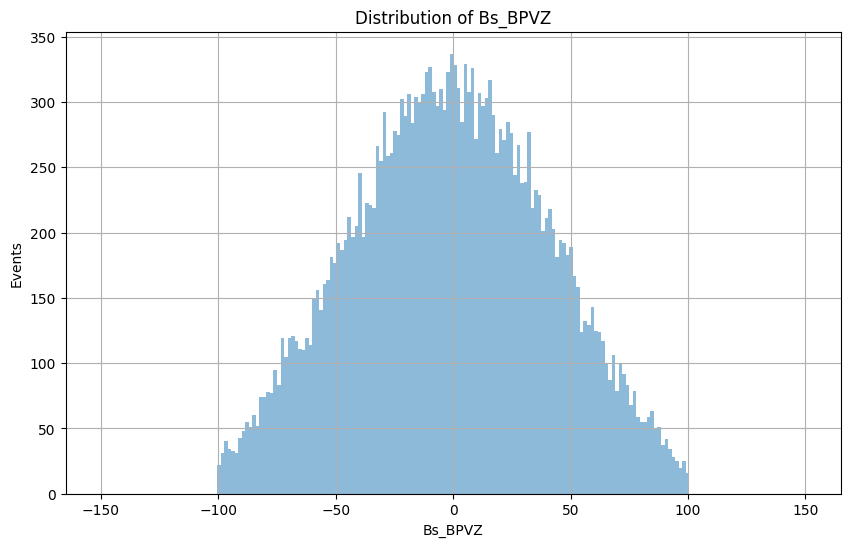

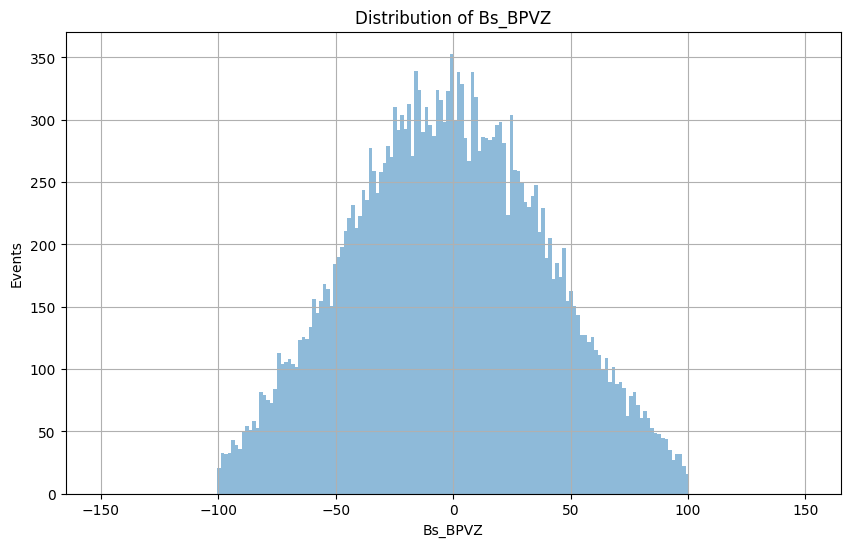

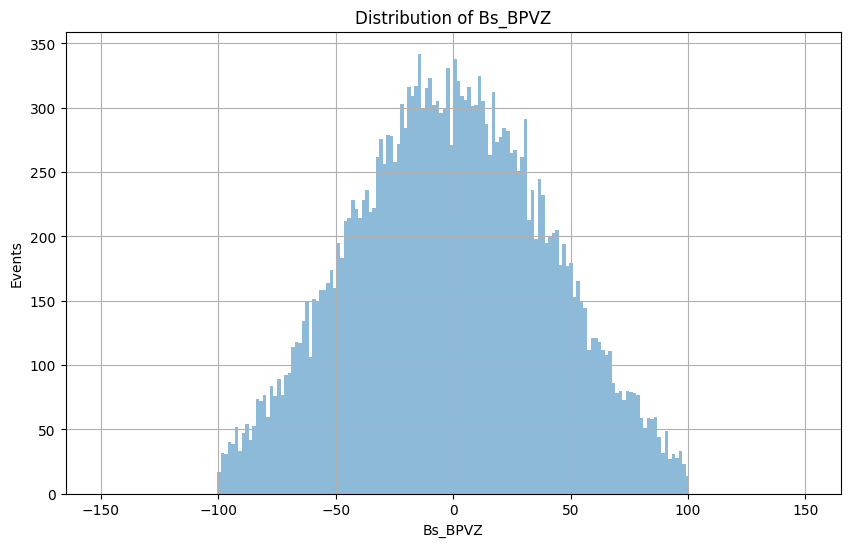

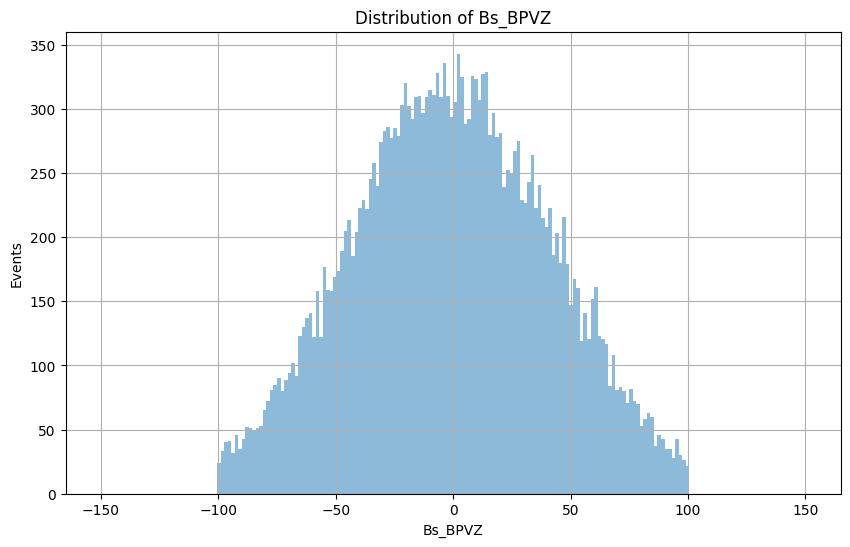

In [91]:
num = np.linspace(0,1,10)
ini_cut_PT = cut_df_c[(cut_df_c['Bs_PT'] > 0) & (cut_df_c['Bs_PT'] < 12500)]
quantiles_PT_prompt = np.quantile(ini_cut_PT['Bs_PT'], num)
cut_fit = quantiles_cutting_data('Bs_PT', ['Bs_BPVZ'],ini_cut_PT,quantiles_PT_prompt,[2,8],[-100,100],nbin=500)

for i in range (len(cut_fit['cut_data'])):
    plt.figure(figsize=(10, 6))
    plt.hist(cut_fit['cut_data'][i], bins=200, range=(-150,150), alpha=0.5)
    plt.title("Distribution of Bs_BPVZ")
    plt.xlabel('Bs_BPVZ')
    plt.ylabel('Events')
    plt.grid(True)
    plt.show()

-----------

# $Prob(wrong\ PV) \propto exp[-\frac{(Z_{PV}-Z_0)^2}{2\sigma_{PV}^2}]*\frac{1}{tan\theta}$

In [92]:
def prob_wrong_PV (sigma,z,z0,cot_theta):
    probwp = np.exp(- (z-z0)**2/(2*sigma**2) ) * cot_theta
    return probwp

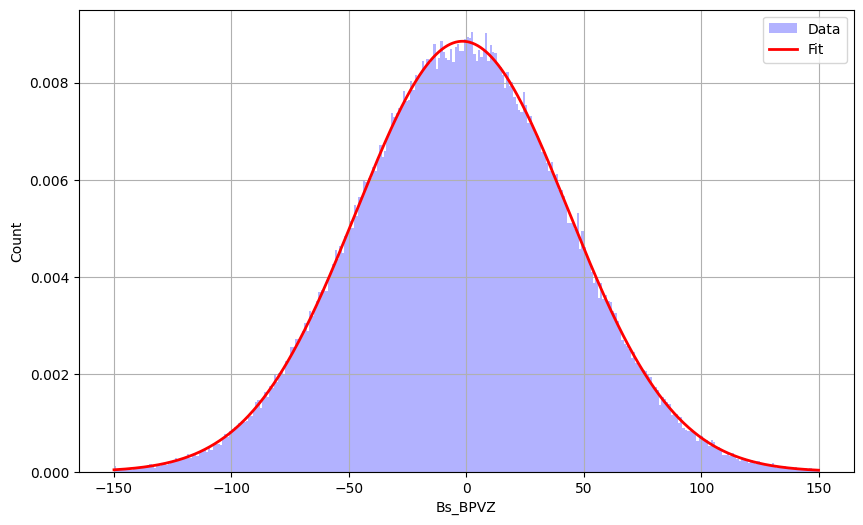

In [102]:
sigma_PV,_ = gaussfit_without_BG('Bs_BPVZ',cut_df_c,[-150,150],plot=True,mean=[-3,3],zfit_spc_lim=[-150,150])

In [103]:
sigma_PV,_ = gaussfit_without_BG('Bs_BPVZ',cut_df_c,[-150,150],plot=False,mean=[-3,3],zfit_spc_lim=[-150,150])
cut_df_c.loc[:, 'Prob_wrong_PV'] = prob_wrong_PV(sigma_PV['sigma']['value'],cut_df_c['Bs_BPVZ'],
                                          sigma_PV['mean']['value'],cut_df_c['Cot_theta'])


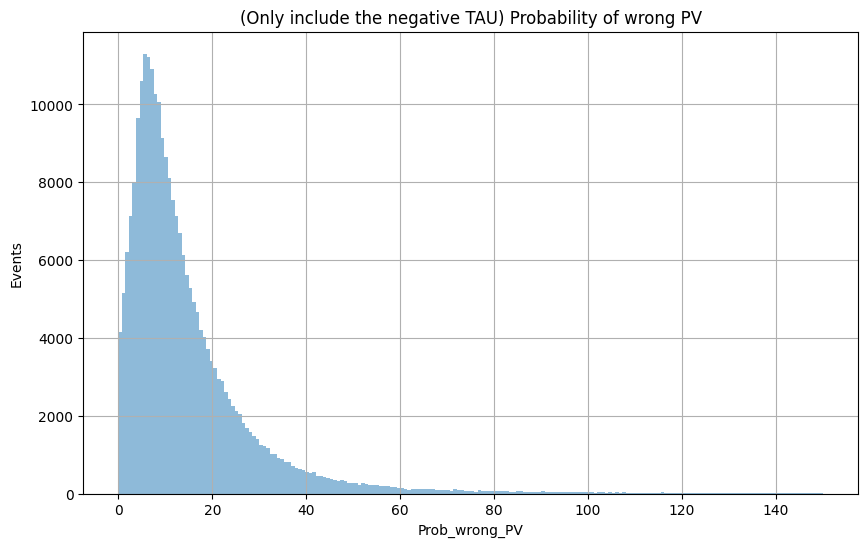

In [105]:
# Prob_wrong_PV
plt.figure(figsize=(10, 6))
#plt.hist(cut_df_c['Prob_wrong_PV'], bins=200, range=(0,150), alpha=0.5,weights = cut_df_c['nsig_weights'])
plt.hist(cut_df_c['Prob_wrong_PV'], bins=200, range=(0,150), alpha=0.5)
plt.title("(Only include the negative TAU) Probability of wrong PV")
plt.xlabel('Prob_wrong_PV')
plt.ylabel('Events')
plt.grid(True)
plt.show()

In [119]:
ini_cut_Prob_wrong_PV

,Bs_DTF_PV_CTAU,Bs_DTF_PV_CTAUERR,RUNNUMBER,NPVs,Jpsi_M,Bs_ETA,Bs_PT,Bs_BPVZ,Bs_BPVIPCHI2,Bs_PZ,Bs_TRUE_LIFETIME,Bs_DTF_PV_TAUERR (ps),Bs_DTF_PV_TAU (ps),Cot_theta,T_Diff (ps),shifted_T_Diff (ps),Prob_wrong_PV
3,1.091343,0.012058,22659218,6,3079.161621,4.873708,496.245514,37.144798,3.105215,32455.189453,0.003715,0.040192,3.637810,65.401474,-0.077209,-0.076053,45.221390
4,0.258914,0.008388,22659218,4,3095.403564,2.746099,11590.852539,44.561298,0.971056,89935.273438,0.000901,0.027959,0.863048,7.759160,-0.038028,-0.036872,4.595770
7,0.561554,0.008727,22659218,8,3102.504639,3.287241,4181.135742,-77.849602,0.947357,55888.128906,0.001884,0.029088,1.871847,13.366734,-0.011842,-0.010686,3.203023
8,0.178866,0.010436,22659218,4,3087.402588,2.988320,5480.886719,-38.676399,4.233104,54268.640625,0.000607,0.034787,0.596219,9.901435,-0.010904,-0.009747,7.063323
14,1.004290,0.008375,22659218,1,3097.784912,3.204259,6885.703613,-43.768501,2.434763,84683.906250,0.003363,0.027916,3.347635,12.298512,-0.014989,-0.013833,7.945107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534278,2.238258,0.013677,22715396,6,3110.307861,3.496879,3600.500244,-38.309399,4.989733,59379.011719,0.007463,0.045591,7.460859,16.491879,-0.002291,-0.001135,11.843251
534279,0.629731,0.009540,22715396,8,3095.959961,3.856741,5683.726074,100.733200,4.168538,134391.515625,0.002113,0.031802,2.099102,23.644966,-0.014312,-0.013155,1.803010
534284,0.825043,0.010852,22715396,4,3096.178223,5.573972,949.529419,42.446899,2.842815,125095.562500,0.002795,0.036173,2.750143,131.744797,-0.045248,-0.044092,81.777824
534286,0.192358,0.006784,22715396,4,3102.965576,3.400936,7171.347656,-12.336500,3.604300,107432.390625,0.000667,0.022613,0.641195,14.980782,-0.026169,-0.025013,14.562609


In [126]:
num = np.linspace(0,1,20)
# Prob_wrong_PV
ini_cut_Prob_wrong_PV = cut_df_c[(cut_df_c['Prob_wrong_PV'] > 0) & (cut_df_c['Prob_wrong_PV'] < 150)]
quantiles_Prob_wrong_PV_prompt = np.quantile(ini_cut_Prob_wrong_PV['Prob_wrong_PV'], num)
rec_cutting_Prob_wrong_PV = quantiles_cutting_data ('Prob_wrong_PV', 'shifted_T_Diff (ps)',
                                         ini_cut_Prob_wrong_PV,quantiles_Prob_wrong_PV_prompt,[2,8],[-100,100],nbin=500)
rec_sig_Prob_wrong_PV = rec_sigma (rec_cutting_Prob_wrong_PV['cut_data'],d_m_B_ps)

num = np.linspace(0,1,20)
# Prob_wrong_PV
ini_cut_Prob_wrong_PV = cut_df_c[(cut_df_c['Prob_wrong_PV'] > 0) & (cut_df_c['Prob_wrong_PV'] < 150)]
quantiles_Prob_wrong_PV_prompt_eff = np.quantile(ini_cut_Prob_wrong_PV['Prob_wrong_PV'], num)
eff_cutting_Prob_wrong_PV = quantiles_cutting_data ('Prob_wrong_PV', 'shifted_T_Diff (ps)', 
                                         ini_cut_Prob_wrong_PV,quantiles_Prob_wrong_PV_prompt_eff,[2,8],[-10,10],nbin=500)

sig_eff_Prob_wrong_PV = array_sig_eff(eff_cutting_Prob_wrong_PV,'cut_data',d_m_B_ps)

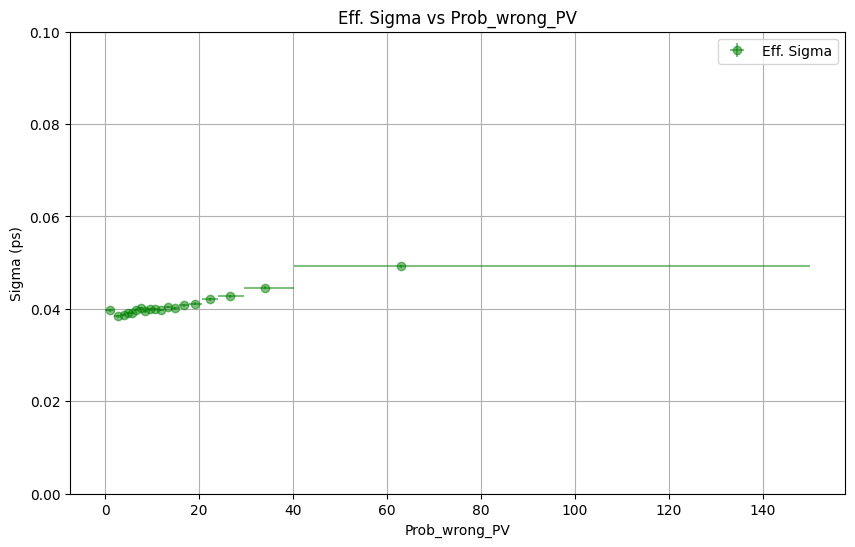

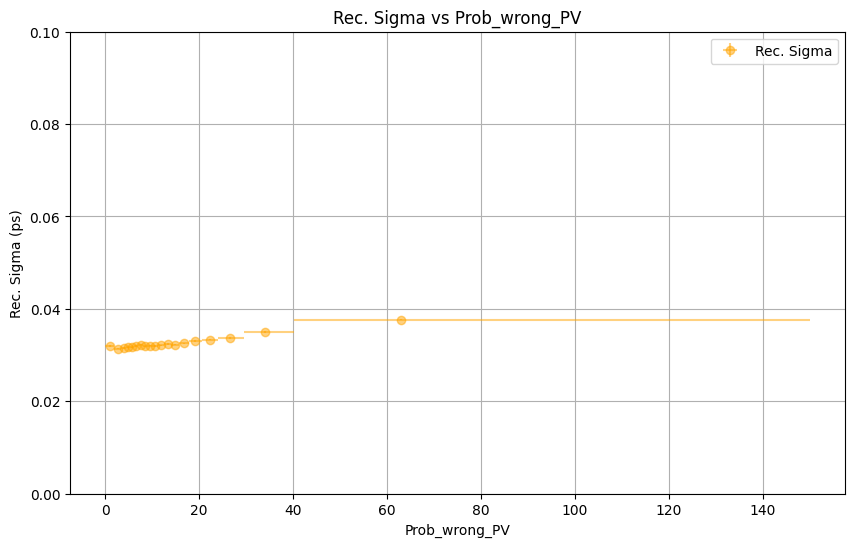

In [131]:
neg_xerr_rec_Prob_wrong_PV = np.array(rec_cutting_Prob_wrong_PV['width_bar']) - \
                  (np.array(rec_cutting_Prob_wrong_PV["mid_bin_point"]) - np.array(rec_cutting_Prob_wrong_PV["average_point"])) 

pos_xerr_rec_Prob_wrong_PV = np.array(rec_cutting_Prob_wrong_PV['width_bar']) + \
                  (np.array(rec_cutting_Prob_wrong_PV["mid_bin_point"]) - np.array(rec_cutting_Prob_wrong_PV["average_point"]))

neg_xerr_eff_Prob_wrong_PV = np.array(eff_cutting_Prob_wrong_PV['width_bar']) - \
                  (np.array(eff_cutting_Prob_wrong_PV["mid_bin_point"]) - np.array(eff_cutting_Prob_wrong_PV["average_point"])) 

pos_xerr_eff_Prob_wrong_PV = np.array(eff_cutting_Prob_wrong_PV['width_bar']) + \
                  (np.array(eff_cutting_Prob_wrong_PV["mid_bin_point"]) - np.array(eff_cutting_Prob_wrong_PV["average_point"])) 


# Plot the fitted lines
plt.figure(figsize=(10, 6))

plt.errorbar(eff_cutting_Prob_wrong_PV["average_point"],sig_eff_Prob_wrong_PV['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_Prob_wrong_PV,pos_xerr_eff_Prob_wrong_PV],yerr=sig_eff_Prob_wrong_PV['sigma(sigma_eff)'],
             label = "Eff. Sigma")

# Customize the plot
plt.title("Eff. Sigma vs Prob_wrong_PV")
plt.xlabel('Prob_wrong_PV')
plt.ylabel("Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


plt.figure(figsize=(10, 6))
plt.errorbar(rec_cutting_Prob_wrong_PV['average_point'],rec_sig_Prob_wrong_PV['sigma_rec'] ,alpha=0.5, fmt='o', color='orange',
            xerr=[neg_xerr_rec_Prob_wrong_PV,pos_xerr_rec_Prob_wrong_PV],yerr=rec_sig_Prob_wrong_PV['sigma(sigma_rec)'],
             label = "Rec. Sigma")

# Customize the plot
plt.title("Rec. Sigma vs Prob_wrong_PV")
plt.xlabel('Prob_wrong_PV')
plt.ylabel("Rec. Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

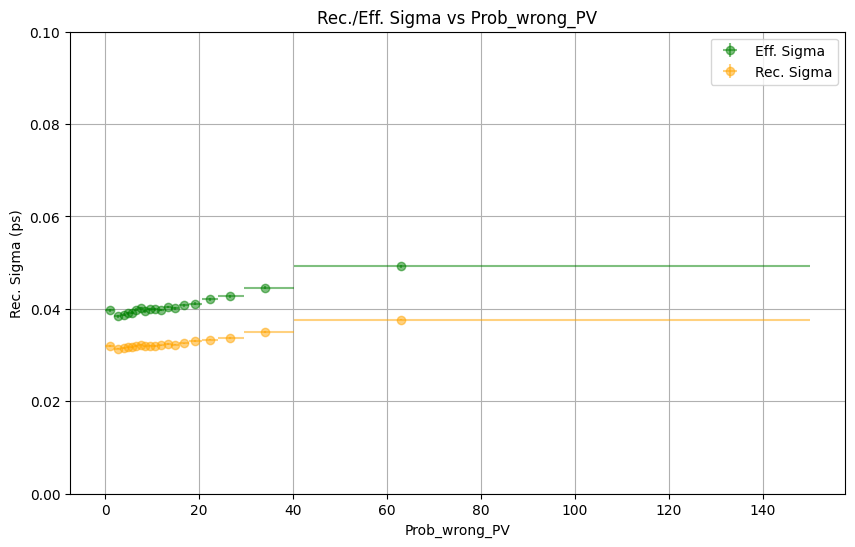

In [132]:
plt.figure(figsize=(10, 6))

plt.errorbar(eff_cutting_Prob_wrong_PV["average_point"],sig_eff_Prob_wrong_PV['sigma_eff'] ,alpha=0.5, fmt='o', color='green',
             xerr=[neg_xerr_eff_Prob_wrong_PV,pos_xerr_eff_Prob_wrong_PV],yerr=sig_eff_Prob_wrong_PV['sigma(sigma_eff)'],
             label = "Eff. Sigma")


plt.errorbar(rec_cutting_Prob_wrong_PV['average_point'],rec_sig_Prob_wrong_PV['sigma_rec'] ,alpha=0.5, fmt='o', color='orange',
            xerr=[neg_xerr_rec_Prob_wrong_PV,pos_xerr_rec_Prob_wrong_PV],yerr=rec_sig_Prob_wrong_PV['sigma(sigma_rec)'],
             label = "Rec. Sigma")

# Customize the plot
plt.title("Rec./Eff. Sigma vs Prob_wrong_PV")
plt.xlabel('Prob_wrong_PV')
plt.ylabel("Rec. Sigma (ps)")
#plt.xlim(0, 0.011)
plt.ylim(0,0.1)
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


## Event mixing 
### Picking close PV, base on,
$$ \Delta x = x_{PV}-y_{SV} + (z_{SV} - z_{PV})*\frac{P_x}{P_z} = IP_x $$
$$ \Delta y = x_{PV}-y_{SV} + (z_{SV} - z_{PV})*\frac{P_y}{P_z} = IP_y $$
$$ IP^2 = \Delta x^2 + \Delta y^2 $$

### 